# **Trabajo Práctico Final 2025 - Procesamiento del Lenguaje Natural - TUIA**

**Alumna**: Valentina Balverdi

**Profesores:**
* Juan Pablo Manson
* Alan Geray
* Constantino Ferrucci


### Instalaciones

In [1]:
!pip -q uninstall -y langchain-classic langgraph-prebuilt langchain-core langchain-text-splitters langchain langchain-community


In [2]:
!pip -q install -U langchain langchain-community chromadb sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.9/475.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 61.4 MB/s eta 0

In [3]:
import langchain_core
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
import chromadb

print("langchain_core:", langchain_core.__version__)
print("chromadb:", chromadb.__version__)
print("Imports OK")


langchain_core: 1.2.0
chromadb: 1.3.7
Imports OK


In [4]:
import os
import glob
import json
import numpy
import pandas as pd
import re

### Modelo a usar, cliente y función de llamadas a LLM

In [5]:
# Inicialización del cliente Gemini
from google import genai
from google.colab import userdata

API_KEY = userdata.get('GOOGLE_API_KEY')
CLIENT = genai.Client(api_key=API_KEY)


In [6]:
MODELO_GEMINI = "gemini-2.0-flash"

In [7]:
def llamar_a_llm(prompt: str) -> str:
    """
    Función única para realizar llamadas al LLM.

    - Centraliza el acceso al modelo (gemini-2.0-flash).
    - Normaliza la salida eliminando fences de código (```json, ```cypher).
    - Devuelve siempre texto limpio.
    """
    resp = CLIENT.models.generate_content(
        model=MODELO_GEMINI,
        contents=[prompt]
    )

    texto = (resp.text or "").strip()

    # Limpieza de fences tipo ```json / ```cypher / ```
    texto = re.sub(r"```(?:json|cypher)?\s*|\s*```","",texto,flags=re.IGNORECASE).strip()

    return texto

# **Descarga y exploración de archivos**

In [8]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

BASE_PATH = "/content/drive/MyDrive/TUIA/NLP/TP_FINAL/fuentes_de_informacion"

# Carga de archivos
path = BASE_PATH

Mounted at /content/drive


#### CSV a dataframe

In [9]:
devoluciones = pd.read_csv(os.path.join(path, "devoluciones.csv"))
inventario = pd.read_csv(os.path.join(path, "inventario_sucursales.csv"))
productos = pd.read_csv(os.path.join(path, "productos.csv"))
ventas = pd.read_csv(os.path.join(path, "ventas_historicas.csv"))
vendedores = pd.read_csv(os.path.join(path, "vendedores.csv"))
tickets = pd.read_csv(os.path.join(path, "tickets_soporte.csv"))

with open(os.path.join(path, "faqs.json"), "r", encoding="utf-8") as f:
    faqs = json.load(f)

#### TXT a documento

In [10]:
# Carga de textos
reviews_dir = os.path.join(path, "resenas_usuarios")
reviews_files = glob.glob(os.path.join(reviews_dir, "*.txt"))

reviews_docs = []

for fp in reviews_files:
    with open(fp, "r", encoding="utf-8") as f:
        text = f.read()

    # Separar encabezado de cuerpo (una línea en blanco entre ambos)
    partes = text.split("\n\n", 1)
    header = partes[0]
    cuerpo = partes[1] if len(partes) > 1 else ""

    # Inicializar campos
    fecha = usuario = telefono = producto_nombre = producto_id = puntaje = provincia = None

    for line in header.splitlines():
        line = line.strip()
        if line.startswith("Fecha:"):
            fecha = line.replace("Fecha:", "").strip()
        elif line.startswith("Usuario:"):
            usuario = line.replace("Usuario:", "").strip()
        elif line.startswith("Teléfono:"):
            telefono = line.replace("Teléfono:", "").strip()
        elif line.startswith("Producto:"):
            # Ej: "Producto: Profesional Batidora de Mano (P0017)"
            m = re.match(r"Producto:\s*(.+)\s+\((P\d+)\)", line)
            if m:
                producto_nombre = m.group(1).strip()
                producto_id = m.group(2).strip()
        elif line.startswith("Puntaje:"):
            # Ej: "Puntaje: 5/5"
            puntaje = line.replace("Puntaje:", "").strip()
        elif line.startswith("Provincia:"):
            provincia = line.replace("Provincia:", "").strip()

    reviews_docs.append({
        "content": cuerpo.strip(),
        "source": os.path.basename(fp),
        "type": "review",
        "fecha": fecha,
        "usuario": usuario,
        "telefono": telefono,
        "producto_id": producto_id,
        "producto_nombre": producto_nombre,
        "puntaje": puntaje,
        "provincia": provincia,
    })


In [11]:
reviews_docs[0]

{'content': 'Buenas! Llegó rápido y funciona de maravilla con Aire Portátil Pro. Lo compré hace una semana y es muy fácil de usar, además de moderno. Ya se lo recomendé a varios amigos. Saludos!',
 'source': 'resena_R03514.txt',
 'type': 'review',
 'fecha': '2024-07-24',
 'usuario': 'Bianca_Romero',
 'telefono': '+54 9 367 8149-1834',
 'producto_id': 'P0156',
 'producto_nombre': 'Aire Portátil Pro',
 'puntaje': '5/5',
 'provincia': 'Neuquén'}

#### Markdowns a documento

In [12]:
import re

def parse_manual_markdown(text, base_metadata=None):
    if base_metadata is None:
        base_metadata = {}

    docs = []

    titulo_manual = None
    seccion_actual = None
    subseccion_actual = None
    buffer = []

    lines = text.splitlines()

    for line in lines:
        m = re.match(r'^(#+)\s+(.*)', line)
        if m:
            hashes, title = m.groups()
            level = len(hashes)
            title = title.strip()

            # Guardar lo acumulado antes de cambiar de encabezado
            if buffer:
                raw = "\n".join(buffer).strip()
                if raw and seccion_actual:
                    if subseccion_actual:
                        content = f"{seccion_actual} - {subseccion_actual}\n\n{raw}"
                        level_out = 3
                    else:
                        content = f"{seccion_actual}\n\n{raw}"
                        level_out = 2

                    docs.append({
                        "content": content,
                        "titulo_manual": titulo_manual,
                        "seccion": seccion_actual,
                        "subseccion": subseccion_actual,
                        "section_level": level_out,
                        **base_metadata
                    })
                buffer = []

            # Procesar encabezado nuevo
            if level == 1:
                titulo_manual = title
                seccion_actual = None
                subseccion_actual = None
            elif level == 2:
                seccion_actual = title
                subseccion_actual = None
            elif level == 3:
                subseccion_actual = title

        else:
            buffer.append(line)

    # Guardar lo último
    if buffer and seccion_actual:
        raw = "\n".join(buffer).strip()
        if raw:
            if subseccion_actual:
                content = f"{seccion_actual} - {subseccion_actual}\n\n{raw}"
                level_out = 3
            else:
                content = f"{seccion_actual}\n\n{raw}"
                level_out = 2

            docs.append({
                "content": content,
                "titulo_manual": titulo_manual,
                "seccion": seccion_actual,
                "subseccion": subseccion_actual,
                "section_level": level_out,
                **base_metadata
            })

    return docs


In [13]:
manuales_dir = os.path.join(path, "manuales_productos")
manuales_files = glob.glob(os.path.join(manuales_dir, "*.md"))


manuales_docs = []

for fp in manuales_files:
    with open(fp, "r", encoding="utf-8") as f:
        text = f.read()

    # Extraer metadata
    titulo_match = re.search(r"#\s*Manual Técnico\s*-\s*(.+)", text)
    producto_nombre = titulo_match.group(1).strip() if titulo_match else None

    modelo_match = re.search(r"\*\*Modelo:\*\*\s*([A-Z0-9]+)", text)
    producto_id = modelo_match.group(1).strip() if modelo_match else None

    marca_match = re.search(r"\*\*Marca:\*\*\s*([A-Za-z0-9]+)", text)
    marca = marca_match.group(1).strip() if marca_match else None

    categoria_match = re.search(r"\*\*Categoría:\*\*\s*(.+)", text)
    categoria = categoria_match.group(1).strip() if categoria_match else None

    base_metadata = {
        "source": os.path.basename(fp),
        "type": "manual",
        "producto_id": producto_id,
        "producto_nombre": producto_nombre,
        "marca": marca,
        "categoria_producto": categoria,
    }

    secciones = parse_manual_markdown(text, base_metadata=base_metadata)
    manuales_docs.extend(secciones)


In [14]:
manuales_docs[:3]

[{'content': 'Índice\n\n1. [Especificaciones Técnicas](#especificaciones-técnicas)\n2. [Componentes Principales](#componentes-principales)\n3. [Procedimientos de Uso](#procedimientos-de-uso)\n4. [Compatibilidad y Relaciones](#compatibilidad-y-relaciones)\n5. [Solución de Problemas](#solución-de-problemas)\n6. [Mantenimiento Preventivo](#mantenimiento-preventivo)\n7. [Información de Garantía](#información-de-garantía)\n8. [Contacto y Soporte](#contacto-y-soporte)\n\n---',
  'titulo_manual': 'Manual Técnico - Procesadora',
  'seccion': 'Índice',
  'subseccion': None,
  'section_level': 2,
  'source': 'manual_P0013_Procesadora.md',
  'type': 'manual',
  'producto_id': 'P0013',
  'producto_nombre': 'Procesadora',
  'marca': 'KitchenPro',
  'categoria_producto': 'Cocina - Preparación'},
 {'content': 'Especificaciones Técnicas\n\n- **Modelo:** P0013\n- **Nombre Comercial:** Procesadora\n- **Categoría:** Cocina - Preparación\n- **Marca:** KitchenPro\n- **Color:** Azul\n- **Potencia:** 1700W\n

### JSON a documento

In [15]:
# Convertir FAQs a documentos
faq_docs = []

for item in faqs:
    pregunta = item["pregunta"]
    respuesta = item["respuesta"]
    producto = item["nombre_producto"]
    categoria = item["categoria"]

    faq_docs.append({
        "content": (
            f"PRODUCTO: {producto}\n"
            f"CATEGORÍA FAQ: {categoria}\n"
            f"PREGUNTA: {pregunta}\n"
            f"RESPUESTA: {respuesta}"
        ),
        "source": f"faq_{item['id_faq']}.json",
        "type": "faq",
        "id_faq": item["id_faq"],
        "id_producto": item["id_producto"],
        "producto_nombre": item["nombre_producto"],
        "categoria_faq": item["categoria"]
    })


In [16]:
faq_docs[0]

{'content': 'PRODUCTO: Licuadora\nCATEGORÍA FAQ: Especificaciones\nPREGUNTA: ¿Qué voltaje requiere?\nRESPUESTA: El Licuadora funciona con 12V. El consumo es de 650W. Recomendamos usar un estabilizador de tensión.',
 'source': 'faq_FAQ00001.json',
 'type': 'faq',
 'id_faq': 'FAQ00001',
 'id_producto': 'P0001',
 'producto_nombre': 'Licuadora',
 'categoria_faq': 'Especificaciones'}

## Información de los datos

In [17]:
# shape tabulares
print("Forma de productos:", productos.shape)
print("Forma de ventas:", ventas.shape)
print("Forma de inventario:", inventario.shape)
print("Forma de devoluciones:", devoluciones.shape)
print("Forma de vendedores:", vendedores.shape)
print("Forma de tickets:", tickets.shape)


Forma de productos: (300, 14)
Forma de ventas: (10000, 15)
Forma de inventario: (4100, 14)
Forma de devoluciones: (800, 14)
Forma de vendedores: (100, 10)
Forma de tickets: (2000, 17)


In [18]:
def stats_longitudes(docs, nombre):
    longitudes = [len(d["content"]) for d in docs]
    if not longitudes:
        print(f"No hay documentos en {nombre}")
        return None

    serie = pd.Series(longitudes)
    print(f"=== {nombre} ===")
    print("Cantidad de documentos:", len(longitudes))
    print("Mínimo:", int(serie.min()))
    print("Máximo:", int(serie.max()))
    print("Promedio:", int(serie.mean()))
    print("Mediana:", int(serie.median()))
    print("Percentil 75:", int(serie.quantile(0.75)))
    print("Percentil 90:", int(serie.quantile(0.90)))
    print()
    return serie

len_reviews  = stats_longitudes(reviews_docs,  "Reseñas")
len_manuales = stats_longitudes(manuales_docs, "Manuales")
len_faqs     = stats_longitudes(faq_docs,      "FAQs")


=== Reseñas ===
Cantidad de documentos: 5015
Mínimo: 132
Máximo: 282
Promedio: 200
Mediana: 203
Percentil 75: 223
Percentil 90: 237

=== Manuales ===
Cantidad de documentos: 964
Mínimo: 133
Máximo: 906
Promedio: 346
Mediana: 358
Percentil 75: 476
Percentil 90: 520

=== FAQs ===
Cantidad de documentos: 3000
Mínimo: 190
Máximo: 365
Promedio: 302
Mediana: 308
Percentil 75: 321
Percentil 90: 332



---

# **Ejercicio 1:** RAG

## **Base de datos Vectorial**
La base de datos vectorial se utiliza para indexar todas las fuentes de información no estructurada o semiestructurada del proyecto, incluyendo:

- Manuales de producto (`.md`)
- Reseñas de usuarios (`.txt`)
- Preguntas frecuentes (`faqs.json`)

Este tipo de contenido es ideal para un esquema (RAG), ya que los usuarios realizan consultas en lenguaje natural y se requiere una búsqueda semántica, no solo coincidencia literal de palabras clave.

In [22]:
# Union para la base vectorial
text_documents = reviews_docs + manuales_docs + faq_docs

In [23]:
import numpy as np

lengths = np.array([len(d["content"]) for d in text_documents])
p95 = int(np.percentile(lengths, 95))
mx  = int(lengths.max())

print(f"Longitudes: p95={p95} caracteres, max={mx} caracteres")

Longitudes: p95=359 caracteres, max=906 caracteres


### **Fragmentación del texto (Text Splitter)**

Previo a la construcción de la base de datos vectorial, se analizó la longitud de los documentos generados a partir del proceso de parseo. Dado que los manuales fueron segmentados de manera semántica por secciones y subsecciones, y que las restantes fuentes (reseñas y FAQs) ya constituyen unidades textuales cortas, no fue necesario aplicar una fragmentación adicional del contenido.

El análisis de longitudes mostró que el percentil 95 de los documentos se encuentra por debajo de los 360 caracteres, con una longitud máxima de 906 caracteres. En función de estos resultados, se definió conceptualmente un tamaño de fragmento (`chunk_size`) de 1000 caracteres, con un solapamiento (`chunk_overlap`) del 15%.

En el conjunto actual de datos, esta configuración no introduce fragmentación adicional, preservando el contexto completo de cada sección semántica.


In [24]:
# Definición conceptual del text splitter (no aplicado)
CHUNK_SIZE = 1000
CHUNK_OVERLAP = int(CHUNK_SIZE * 0.15)


### **Modelo de Embeddings**

### Modelo de Embeddings

Para la representación vectorial de los documentos se utilizó un modelo de embeddings multilingüe con soporte para idioma español.

Se seleccionó el modelo **`intfloat/multilingual-e5-small`**, disponible en Hugging Face, por las siguientes razones:

- Soporta múltiples idiomas, incluyendo español.
- Presenta un buen equilibrio entre calidad semántica y eficiencia computacional.
- Es considerablemente más liviano que otros modelos de mayor tamaño.
- Está diseñado específicamente para tareas de recuperación de información (Information Retrieval), lo cual lo hace apropiado para esquemas RAG.

Este modelo permite generar embeddings densos que representan el significado de los textos, facilitando la comparación semántica entre consultas de usuario y fragmentos de información almacenados en la base vectorial.

In [25]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embedding_model_name = "intfloat/multilingual-e5-small"

embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model_name,
    encode_kwargs={"normalize_embeddings": True}
)


/tmp/ipython-input-2633435730.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

### **Almacenamiento en ChromaDB**

Para almacenar y consultar los embeddings se utilizó **ChromaDB** como base de datos vectorial. Chroma permite:

- Persistencia local del índice vectorial.
- Búsqueda semántica por similitud a partir de una consulta en lenguaje natural.
- Almacenamiento de metadatos por documento, lo que permite aplicar filtros (por ejemplo, filtrar por `producto_id` o por tipo de fuente: manual, faq, review, ticket).

Dado que los documentos ya se encuentran segmentados semánticamente (especialmente los manuales por secciones y subsecciones) y su longitud máxima es menor a 1000 caracteres, se almacenan directamente como unidades completas, evitando fragmentación innecesaria.

In [26]:
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
import os, shutil

In [27]:
docs = [
    Document(
        page_content=d["content"],
        metadata={k: v for k, v in d.items() if k != "content"}
    )
    for d in text_documents
]

# Subsets por tipo
docs_manual = [d for d in docs if d.metadata.get("type") == "manual"]
docs_faq = [d for d in docs if d.metadata.get("type") == "faq"]
docs_review = [d for d in docs if d.metadata.get("type") == "review"]

In [28]:
BUILD_CHROMA = False  # cambiar a True SOLO cuando se quiera regenerar la base

if BUILD_CHROMA:
    local_persist_dir = "/content/chroma_db"
    os.makedirs(local_persist_dir, exist_ok=True)

    vectordb = Chroma.from_documents(
        documents=docs,
        embedding=embeddings,
        persist_directory=local_persist_dir,
        collection_name="electrodomesticos_rag"
    )

    drive_target = "/content/drive/MyDrive/TUIA/NLP/TP_FINAL/chroma_db"

    if os.path.exists(drive_target):
        shutil.rmtree(drive_target)

    shutil.copytree(local_persist_dir, drive_target)
    print("Chroma DB construida y copiada a Drive")


In [29]:
persist_dir = "/content/drive/MyDrive/TUIA/NLP/TP_FINAL/chroma_db"

vectordb = Chroma(
    persist_directory=persist_dir,
    embedding_function=embeddings,
    collection_name="electrodomesticos_rag"
)


/tmp/ipython-input-3505873731.py:3: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectordb = Chroma(


### **Función de Búsqueda Vectorial**

Esta función constituye la interfaz de acceso a la base de datos vectorial. Su objetivo es recuperar los fragmentos de información más relevantes en función de una consulta en lenguaje natural, utilizando similitud semántica entre embeddings.

La función recibe como parámetros:
- la consulta del usuario (`query`),
- la cantidad de fragmentos a recuperar (`k`),
- y un conjunto opcional de filtros basados en metadata (`filters`), que permiten restringir la búsqueda a un subconjunto específico de documentos (por ejemplo, manuales de un producto determinado).

El resultado de la función es una lista de fragmentos ordenados por similitud semántica, cada uno acompañado de su metadata asociada.


In [30]:
def _normalizar_filtro_chroma(filters: dict | None):
    if not filters:
        return None

    # Si ya viene en formato Chroma ($and/$or), se deja
    if any(k.startswith("$") for k in filters.keys()):
        return filters

    # Si viene como dict simple, se convierte
    if len(filters) == 1:
        return filters
    return {"$and": [{k: v} for k, v in filters.items()]}


def busqueda_vectorial(query: str, k: int = 5, filters: dict | None = None):
    """Devuelve Documents (sin score), compatible con tus pruebas actuales."""
    where = _normalizar_filtro_chroma(filters)
    return vectordb.similarity_search(query=query, k=k, filter=where)


def busqueda_vectorial_con_score(query: str, k: int = 5, filters: dict | None = None):
    """Devuelve (Document, score_distancia) desde Chroma."""
    where = _normalizar_filtro_chroma(filters)
    return vectordb.similarity_search_with_score(query=query, k=k, filter=where)


**Validación:** se probaron consultas sin filtros (recuperando FAQs relevantes) y con filtros por `type` y `producto_id` (recuperando subsecciones específicas del manual correspondiente).


In [31]:
# sin filtros
res = busqueda_vectorial("¿Qué voltaje requiere la licuadora?", k=5)
print(res)

# filtrando por manual de un producto
res = busqueda_vectorial(
    "ruido excesivo o vibraciones",
    k=2,
    filters={"$and": [{"type":"manual"}, {"producto_id":"P0013"}]}
)
print(res)


[Document(metadata={'id_producto': 'P0001', 'producto_nombre': 'Licuadora', 'source': 'faq_FAQ00001.json', 'id_faq': 'FAQ00001', 'categoria_faq': 'Especificaciones', 'type': 'faq'}, page_content='PRODUCTO: Licuadora\nCATEGORÍA FAQ: Especificaciones\nPREGUNTA: ¿Qué voltaje requiere?\nRESPUESTA: El Licuadora funciona con 12V. El consumo es de 650W. Recomendamos usar un estabilizador de tensión.'), Document(metadata={'source': 'faq_FAQ00078.json', 'id_faq': 'FAQ00078', 'producto_nombre': 'Ultra Licuadora', 'id_producto': 'P0008', 'type': 'faq', 'categoria_faq': 'Especificaciones'}, page_content='PRODUCTO: Ultra Licuadora\nCATEGORÍA FAQ: Especificaciones\nPREGUNTA: ¿Qué voltaje requiere?\nRESPUESTA: El Ultra Licuadora funciona con 12V. El consumo es de 600W. Recomendamos usar un estabilizador de tensión.'), Document(metadata={'type': 'faq', 'categoria_faq': 'Especificaciones', 'producto_nombre': 'Compacto Licuadora', 'id_producto': 'P0004', 'id_faq': 'FAQ00036', 'source': 'faq_FAQ00036.jso

In [32]:
for d in res[:3]:
    print(d.metadata)
    print(d.page_content[:200], "...\n")


{'section_level': 3, 'categoria_producto': 'Cocina - Preparación', 'producto_id': 'P0013', 'titulo_manual': 'Manual Técnico - Procesadora', 'producto_nombre': 'Procesadora', 'marca': 'KitchenPro', 'type': 'manual', 'source': 'manual_P0013_Procesadora.md', 'subseccion': 'Ruido excesivo o vibraciones', 'seccion': 'Solución de Problemas'}
Solución de Problemas - Ruido excesivo o vibraciones

**Posibles causas:**

- Piezas mal ensambladas
- Ingredientes muy duros o congelados
- Sobrecarga de alimentos en el recipiente
- Base no está niv ...

{'categoria_producto': 'Cocina - Preparación', 'producto_id': 'P0013', 'section_level': 3, 'producto_nombre': 'Procesadora', 'titulo_manual': 'Manual Técnico - Procesadora', 'marca': 'KitchenPro', 'seccion': 'Solución de Problemas', 'type': 'manual', 'source': 'manual_P0013_Procesadora.md', 'subseccion': 'Pérdida de potencia o velocidad reducida'}
Solución de Problemas - Pérdida de potencia o velocidad reducida

**Posibles causas:**

- Sobrecarga de in

## **Base Tabular** (datos estadísticos)
Para resolver consultas donde el usuario necesita información estructurada.

Las tablas provienen de los archivos CSV del dataset:
- productos.csv
- ventas_historicas.csv
- inventario_sucursales.csv
- devoluciones.csv
- vendedores.csv
- tickets_soporte.csv

In [33]:
tablas_tabulares = {
    "productos": productos,
    "inventario": inventario,
    "ventas": ventas,
    "devoluciones": devoluciones,
    "vendedores": vendedores,
    "tickets": tickets,
}

{nombre: df.shape for nombre, df in tablas_tabulares.items()}


{'productos': (300, 14),
 'inventario': (4100, 14),
 'ventas': (10000, 15),
 'devoluciones': (800, 14),
 'vendedores': (100, 10),
 'tickets': (2000, 17)}

### Generar estructura e información para el llm

In [34]:
# Funcion para obtener información relevante de las tablas

def generar_estructura_para_llm(nombre_df: str, df: pd.DataFrame, max_uniques: int = 20, sample_text: int = 5):
    estructura = {"nombre_df": nombre_df, "cantidad_filas": int(len(df)), "cantidad_columnas": int(df.shape[1]), "resumen_columnas": {}}

    for col in df.columns:
        serie = df[col]
        info = {}
        s = serie.dropna()

        if pd.api.types.is_bool_dtype(serie):
            info["tipo"] = "booleano"
            info["pct_true"] = float(serie.mean()) if len(s) else None

        elif pd.api.types.is_numeric_dtype(serie):
            info["tipo"] = "numerico"
            if len(s):
                info.update({"min": float(s.min()), "max": float(s.max())})
            else:
                info.update({"min": None, "max": None})

        else:
            # intentar fecha con muestra (sin convertir toda la columna)
            es_fecha = False
            if len(s):
                muestra = s.astype(str).head(30)
                parsed = pd.to_datetime(muestra, errors="coerce", utc=True)
                es_fecha = parsed.notna().mean() > 0.8

            if es_fecha:
                info["tipo"] = "fecha"
            else:
                n_unique = int(serie.nunique(dropna=True))
                if n_unique <= max_uniques:
                    info["tipo"] = "categorico"
                    info["valores_unicos"] = s.astype(str).unique().tolist()[:max_uniques]
                else:
                    info["tipo"] = "texto_libre"
                    info["num_valores_unicos"] = n_unique
                    info["ejemplos"] = s.astype(str).head(sample_text).tolist()

        estructura["resumen_columnas"][col] = info

    return estructura

In [35]:
# Funcion para pasar la estructura a un string para el prompt

def estructura_a_string(estructura: dict) -> str:
    lineas = []
    lineas.append(f"TABLA: {estructura['nombre_df']}")
    lineas.append(f"Filas: {estructura['cantidad_filas']} | Columnas: {estructura['cantidad_columnas']}")
    lineas.append("Columnas disponibles:")

    for col, info in estructura["resumen_columnas"].items():
        tipo = info["tipo"]

        if tipo == "numerico":
            lineas.append(
                f"- {col}: numérico | min={info.get('min')} max={info.get('max')} ")
        elif tipo == "categorico":
            vals = ", ".join(map(str, info.get("valores_unicos", [])))
            lineas.append(f"- {col}: categórico | valores posibles: {vals}")
        else:
            lineas.append(f"- {col}: texto libre / alta cardinalidad (≈{info.get('num_valores_unicos')} valores distintos)")

    return "\n".join(lineas)


In [36]:
esquemas_tabulares = {n: generar_estructura_para_llm(n, df) for n, df in tablas_tabulares.items()}
descripciones_tablas = {n: estructura_a_string(esq) for n, esq in esquemas_tabulares.items()}

/tmp/ipython-input-681472997.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(muestra, errors="coerce", utc=True)
/tmp/ipython-input-681472997.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(muestra, errors="coerce", utc=True)
/tmp/ipython-input-681472997.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(muestra, errors="coerce", utc=True)
/tmp/ipython-input-681472997.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensur

### Creación del prompt

In [37]:
import json

def armar_prompt_tabular(query_usuario: str) -> str:
    """
    Prompt para que el LLM devuelva EXCLUSIVAMENTE un plan JSON
    para consultas tabulares sobre DataFrames de pandas.
    """

    tablas = list(tablas_tabulares.keys())

    ejemplo_json = {
        "tabla": "productos",
        "filtros": [
            {"columna": "precio_usd", "operador": "<=", "valor": 200},
            {"columna": "nombre", "operador": "contains", "valor": "licuadora"}
        ],
        "columnas_a_mostrar": ["id_producto", "nombre", "precio_usd"]
    }

    partes = []

    partes.append(
        "Sos un asistente experto en análisis de datos tabulares.\n"
        "Disponés de varias tablas (DataFrames) ya cargadas.\n\n"
        "Tu tarea es interpretar la consulta del usuario y devolver "
        "EXCLUSIVAMENTE un JSON válido que describa un PLAN de consulta.\n\n"

        "El JSON debe contener:\n"
        "- 'tabla': nombre de UNA tabla principal\n"
        "- 'filtros': lista de filtros estructurados\n"
        "- 'columnas_a_mostrar': columnas a devolver\n"

        "REGLAS ESTRICTAS:\n"
        "- Respondé SOLO el JSON. Sin texto adicional.\n"
        "- NO devuelvas código.\n"
        "- NO inventes tablas ni columnas.\n"
        "- Usá SOLO columnas que existan en la tabla elegida.\n"
        "- Operadores permitidos: ==, <=, >=, <, >, contains, in, between, isnull, notnull\n"
        "- 'contains' es case-insensitive.\n"
        "- 'in' requiere que el valor sea una lista.\n\n"

        "Si NO es posible responder la consulta con UNA sola tabla, "
        "o no hay información suficiente, devolvé:\n"
        "{ \"error\": \"explicación breve del problema\" }\n\n"

        f"Tablas disponibles: {tablas}\n\n"
        "Formato esperado (ejemplo):\n"
        f"{json.dumps(ejemplo_json, ensure_ascii=False, indent=2)}\n"
    )

    partes.append("\nResumen de tablas (metadatos, NO datos crudos):\n")
    for nombre, desc in descripciones_tablas.items():
        partes.append(f"\n### {nombre}\n{desc}\n")

    partes.append("\nConsulta del usuario:\n")
    partes.append(query_usuario)

    return "\n".join(partes)



In [38]:
def aplicar_filtros_tabulares(tabla, filtros, columnas_a_mostrar=None, limite=None):
    df = tablas_tabulares[tabla].copy()

    for f in filtros or []:
        col = f["columna"]; op = f["operador"]; val = f.get("valor")

        if op in {"<=" ,">=","<",">"} and pd.api.types.is_numeric_dtype(df[col]):
            val = float(val)

        if op == "==": df = df[df[col] == val]
        elif op == "<=": df = df[df[col] <= val]
        elif op == ">=": df = df[df[col] >= val]
        elif op == "<": df = df[df[col] < val]
        elif op == ">": df = df[df[col] > val]
        elif op == "contains": df = df[df[col].astype(str).str.contains(str(val), case=False, na=False)]
        elif op == "in":
            if not isinstance(val, list): raise ValueError("'in' requiere lista")
            df = df[df[col].isin(val)]
        elif op == "between":
            lo, hi = val
            df = df[(df[col] >= lo) & (df[col] <= hi)]
        elif op == "isnull": df = df[df[col].isna()]
        elif op == "notnull": df = df[df[col].notna()]
        else: raise ValueError(f"Operador no soportado: {op}")

    if columnas_a_mostrar:
        columnas_a_mostrar = [c for c in columnas_a_mostrar if c in df.columns]
        df = df[columnas_a_mostrar]

    if limite: df = df.head(int(limite))
    return df


### Funciones de ejecución

In [39]:
OPS_PERMITIDOS = {"==","<=",">=","<",">","contains","in","between","isnull","notnull"}

def validar_plan_tabular(plan, tablas_tabulares):
    if "error" in plan:
        return False, plan["error"]

    tabla = plan.get("tabla")
    if tabla not in tablas_tabulares:
        return False, "Tabla inexistente."

    df = tablas_tabulares[tabla]
    for f in plan.get("filtros", []):
        col = f.get("columna")
        op  = f.get("operador")
        if col not in df.columns:
            return False, f"Columna inexistente: {col}"
        if op not in OPS_PERMITIDOS:
            return False, f"Operador no permitido: {op}"

    cols = plan.get("columnas_a_mostrar")
    if cols:
        bad = [c for c in cols if c not in df.columns]
        if bad:
            return False, f"Columnas a mostrar inválidas: {bad}"
    return True, ""


In [40]:
def ejecutar_consulta_tabular(query_usuario):
    prompt = armar_prompt_tabular(query_usuario)
    texto = llamar_a_llm(prompt)

    try:
        plan = json.loads(texto)
    except json.JSONDecodeError:
        prompt2 = prompt + "\n\nIMPORTANTE: Devolvé SOLO JSON válido (sin texto extra)."
        texto2 = llamar_a_llm(prompt2)
        plan = json.loads(texto2)

    ok, err = validar_plan_tabular(plan, tablas_tabulares)
    if not ok:
        return pd.DataFrame(), {"error": err, "plan_llm": plan}

    res = aplicar_filtros_tabulares(
        tabla=plan["tabla"],
        filtros=plan.get("filtros", []),
        columnas_a_mostrar=plan.get("columnas_a_mostrar"),
        limite=plan.get("limite"),
    )
    return res, plan


In [41]:
query = "¿Cuáles son las licuadoras de menos de 500 dólares?"
res, filtros = ejecutar_consulta_tabular(query)
res.head()


,id_producto,nombre,precio_usd
0,P0001,Licuadora,283.63
2,P0003,Plus Licuadora Pro,329.07
3,P0004,Compacto Licuadora,259.42


In [42]:
print(filtros)


{'tabla': 'productos', 'filtros': [{'columna': 'nombre', 'operador': 'contains', 'valor': 'licuadora'}, {'columna': 'precio_usd', 'operador': '<', 'valor': 500}], 'columnas_a_mostrar': ['id_producto', 'nombre', 'precio_usd']}


## **Base de datos de grafo**
En esta sección se construye una **base de datos de grafos** para modelar relaciones estructurales entre productos de una empresa de electrodomésticos.

El objetivo es representar información que resulta más natural y eficiente de consultar mediante grafos, como:
- pertenencia a categorías,
- compatibilidades entre productos,
- relación entre productos y preguntas frecuentes (FAQs).

La base se implementa utilizando **Neo4j**, que permite consultas mediante el lenguaje **Cypher**, cumpliendo con los requisitos del enunciado.

### Preparación de DataFrames de nodos y relaciones

Antes de cargar la información en Neo4j, se preparan **DataFrames intermedios** que representan explícitamente:

- Nodos del grafo (entidades)
- Relaciones entre nodos

#### Nodos del grafo

Se definen los siguientes tipos de nodos:

- **Producto**: información principal del catálogo (id, nombre, categoría, marca, voltaje, etc.).
- **Categoria**: categoría comercial del producto.
- **FAQ**: preguntas frecuentes asociadas a un producto, utilizadas para consultas técnicas como voltaje, garantía o uso.

Cada nodo se construye a partir de las fuentes tabulares y documentales originales.

In [43]:
# Producto
df_productos_grafo = (
    productos[["id_producto","nombre","categoria","subcategoria","marca","voltaje","potencia_w","precio_usd"]]
    .drop_duplicates(subset=["id_producto"])
    .copy()
)

for c in ["id_producto","nombre","categoria","subcategoria","marca","voltaje"]:
    df_productos_grafo[c] = df_productos_grafo[c].astype(str).str.strip()

ids_productos = set(df_productos_grafo["id_producto"].unique())

In [44]:
# Categoria
df_categorias = (
    df_productos_grafo[["categoria"]]
    .dropna()
    .drop_duplicates()
    .rename(columns={"categoria":"nombre"})
    .copy()
)
df_categorias["nombre"] = df_categorias["nombre"].astype(str).str.strip()

In [45]:
# FAQ (nodos)
df_faqs_grafo = (
    pd.DataFrame(faq_docs)[["id_faq","id_producto","producto_nombre","categoria_faq","content","source"]]
    .drop_duplicates(subset=["id_faq"])
    .copy()
)
for c in ["id_faq","id_producto","producto_nombre","categoria_faq","source"]:
    df_faqs_grafo[c] = df_faqs_grafo[c].astype(str).str.strip()

# FAQs de productos existentes
df_faqs_grafo = df_faqs_grafo[df_faqs_grafo["id_producto"].isin(ids_productos)].copy()

#### Relaciones del grafo

Se modelan tres relaciones principales:

1. **(Producto)-[:PERTENECE_A]->(Categoria)**  
   Representa la pertenencia de un producto a una categoría comercial.

2. **(Producto)-[:COMPATIBLE_CON]->(Producto)**  
   Representa compatibilidades entre productos, extraídas de los manuales técnicos.

3. **(Producto)-[:TIENE_FAQ]->(FAQ)**  
   Asocia cada producto con sus preguntas frecuentes.

Estas relaciones permiten responder consultas que requieren navegación entre entidades relacionadas.


In [46]:
# Producto -> Categoria
df_rel_producto_categoria = (
    df_productos_grafo[["id_producto","categoria"]]
    .dropna()
    .drop_duplicates()
    .rename(columns={"categoria":"nombre_categoria"})
    .copy()
)
df_rel_producto_categoria["nombre_categoria"] = df_rel_producto_categoria["nombre_categoria"].astype(str).str.strip()

In [47]:
# Producto -> FAQ
df_rel_producto_faq = (
    df_faqs_grafo[["id_producto","id_faq"]]
    .dropna()
    .drop_duplicates()
    .copy()
)

In [48]:
# Producto -> Producto (Compatibilidades)
def extraer_compatibilidades(manuales_docs):
    filas = []
    patron_item = re.compile(r"-\s*\*\*(.+?)\*\*\s*\(`(P\d{4})`\)", re.IGNORECASE)

    for d in manuales_docs:
        if d.get("seccion", "").strip().lower() != "compatibilidad y relaciones":
            continue

        src = str(d.get("producto_id") or "").strip()
        if not src:
            continue

        texto = d.get("content", "")
        lines = texto.splitlines()

        for line in lines:
            m = patron_item.search(line)
            if m:
                filas.append({
                    "id_producto_src": src,
                    "id_producto_dst": m.group(2).strip(),
                    "nombre_dst": m.group(1).strip(),
                    "comparte": None,
                    "source": d.get("source")
                })
                continue

            m2 = re.search(r"Comparte:\s*(.+)", line, re.IGNORECASE)
            if m2 and len(filas) > 0 and filas[-1]["id_producto_src"] == src:
                filas[-1]["comparte"] = m2.group(1).strip()

    dfc = pd.DataFrame(filas).drop_duplicates(subset=["id_producto_src","id_producto_dst","comparte"])
    return dfc

df_rel_compatibilidades = extraer_compatibilidades(manuales_docs)

# filtrar compatibilidades a productos existentes en productos.csv
df_rel_compatibilidades = df_rel_compatibilidades[
    df_rel_compatibilidades["id_producto_src"].isin(ids_productos) &
    df_rel_compatibilidades["id_producto_dst"].isin(ids_productos)
].copy()

In [49]:
print("Nodos -> productos:", len(df_productos_grafo))
print("Nodos -> categorias:", len(df_categorias))
print("Nodos -> faqs:", len(df_faqs_grafo))
print("Rel -> producto_categoria:", len(df_rel_producto_categoria))
print("Rel -> producto_faq:", len(df_rel_producto_faq))
print("Rel -> compatibilidades:", len(df_rel_compatibilidades))

Nodos -> productos: 300
Nodos -> categorias: 4
Nodos -> faqs: 3000
Rel -> producto_categoria: 300
Rel -> producto_faq: 3000
Rel -> compatibilidades: 250


### Conexión a Neo4j

Se establece conexión con una instancia de **Neo4j** utilizando el driver oficial de Python.

Las credenciales (URI, usuario y contraseña) se configuran externamente, permitiendo reutilizar el código tanto en entornos locales como en Neo4j Aura.


In [50]:
!pip -q install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 6.5 MB/s eta 0:00:00


#### Creación de constraints de unicidad

Antes de cargar los datos, se crean **constraints de unicidad** para garantizar la integridad del grafo:

- `Producto.id_producto`
- `Categoria.nombre`
- `FAQ.id_faq`

Estos constraints aseguran que la carga sea **idempotente**, evitando duplicados incluso si el proceso se ejecuta múltiples veces.

In [51]:
from neo4j import GraphDatabase
import pandas as pd

NEO4J_URI = "neo4j+s://1830c5fb.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = userdata.get("NEO4_KEY")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def ejecutar_cypher(query, params=None):
    with driver.session() as session:
        res = session.run(query, params or {})
        return [r.data() for r in res]

ejecutar_cypher("RETURN 1 AS ok")



[{'ok': 1}]

In [52]:
def crear_constraints():
    queries = [
        "CREATE CONSTRAINT producto_id IF NOT EXISTS FOR (p:Producto) REQUIRE p.id_producto IS UNIQUE",
        "CREATE CONSTRAINT categoria_nombre IF NOT EXISTS FOR (c:Categoria) REQUIRE c.nombre IS UNIQUE",
        "CREATE CONSTRAINT faq_id IF NOT EXISTS FOR (f:FAQ) REQUIRE f.id_faq IS UNIQUE",
    ]
    for q in queries:
        ejecutar_cypher(q)

crear_constraints()


#### Carga de nodos en el grafo

Los nodos se insertan en Neo4j utilizando la cláusula `MERGE`, lo que permite:

- crear el nodo si no existe,
- reutilizarlo si ya fue creado previamente

Productos

In [53]:
def cargar_productos(df_productos_grafo: pd.DataFrame, batch_size=1000):
    q = """
    UNWIND $rows AS row
    MERGE (p:Producto {id_producto: row.id_producto})
    SET p.nombre = row.nombre,
        p.categoria = row.categoria,
        p.subcategoria = row.subcategoria,
        p.marca = row.marca,
        p.voltaje = row.voltaje,
        p.potencia_w = row.potencia_w,
        p.precio_usd = row.precio_usd
    """
    rows = df_productos_grafo.fillna("").to_dict("records")
    for i in range(0, len(rows), batch_size):
        ejecutar_cypher(q, {"rows": rows[i:i+batch_size]})

cargar_productos(df_productos_grafo)


Categorías

In [54]:
def cargar_categorias(df_categorias: pd.DataFrame, batch_size=1000):
    q = """
    UNWIND $rows AS row
    MERGE (c:Categoria {nombre: row.nombre})
    """
    rows = df_categorias.fillna("").to_dict("records")
    for i in range(0, len(rows), batch_size):
        ejecutar_cypher(q, {"rows": rows[i:i+batch_size]})

cargar_categorias(df_categorias)


FAQs

In [55]:
def cargar_faqs(df_faqs_grafo: pd.DataFrame, batch_size=1000):
    q = """
    UNWIND $rows AS row
    MERGE (f:FAQ {id_faq: row.id_faq})
    SET f.producto_nombre = row.producto_nombre,
        f.categoria_faq = row.categoria_faq,
        f.content = row.content,
        f.source = row.source
    """
    rows = df_faqs_grafo.fillna("").to_dict("records")
    for i in range(0, len(rows), batch_size):
        ejecutar_cypher(q, {"rows": rows[i:i+batch_size]})

cargar_faqs(df_faqs_grafo)


#### Carga de relaciones en el grafo

Una vez creados los nodos, se insertan las relaciones entre ellos.

Cada relación se genera mediante `MERGE`, asegurando que:
- no se creen relaciones duplicadas,
- se mantenga la coherencia del grafo.

En el caso de las compatibilidades, se almacenan propiedades adicionales como el componente compartido.


Producto → Categoría (PERTENECE_A)

In [56]:
def cargar_rel_producto_categoria(df_rel_producto_categoria: pd.DataFrame, batch_size=2000):
    q = """
    UNWIND $rows AS row
    MATCH (p:Producto {id_producto: row.id_producto})
    MATCH (c:Categoria {nombre: row.nombre_categoria})
    MERGE (p)-[:PERTENECE_A]->(c)
    """
    rows = df_rel_producto_categoria.fillna("").to_dict("records")
    for i in range(0, len(rows), batch_size):
        ejecutar_cypher(q, {"rows": rows[i:i+batch_size]})

cargar_rel_producto_categoria(df_rel_producto_categoria)


Producto → FAQ (TIENE_FAQ)

In [57]:
def cargar_rel_producto_faq(df_rel_producto_faq: pd.DataFrame, batch_size=2000):
    q = """
    UNWIND $rows AS row
    MATCH (p:Producto {id_producto: row.id_producto})
    MATCH (f:FAQ {id_faq: row.id_faq})
    MERGE (p)-[:TIENE_FAQ]->(f)
    """
    rows = df_rel_producto_faq.fillna("").to_dict("records")
    for i in range(0, len(rows), batch_size):
        ejecutar_cypher(q, {"rows": rows[i:i+batch_size]})

cargar_rel_producto_faq(df_rel_producto_faq)


Producto ↔ Producto (COMPATIBLE_CON)

In [58]:
def cargar_rel_compatibilidades(df_rel_compatibilidades: pd.DataFrame, batch_size=2000):
    q = """
    UNWIND $rows AS row
    MATCH (p1:Producto {id_producto: row.id_producto_src})
    MATCH (p2:Producto {id_producto: row.id_producto_dst})
    MERGE (p1)-[r:COMPATIBLE_CON]->(p2)
    SET r.comparte = row.comparte,
        r.source = row.source
    """
    rows = df_rel_compatibilidades.fillna("").to_dict("records")
    for i in range(0, len(rows), batch_size):
        ejecutar_cypher(q, {"rows": rows[i:i+batch_size]})

cargar_rel_compatibilidades(df_rel_compatibilidades)


#### Verificación

In [59]:
print("Productos:", ejecutar_cypher("MATCH (p:Producto) RETURN count(p) AS n")[0]["n"])
print("Categorias:", ejecutar_cypher("MATCH (c:Categoria) RETURN count(c) AS n")[0]["n"])
print("FAQs:", ejecutar_cypher("MATCH (f:FAQ) RETURN count(f) AS n")[0]["n"])
print("PERTENECE_A:", ejecutar_cypher("MATCH ()-[r:PERTENECE_A]->() RETURN count(r) AS n")[0]["n"])
print("TIENE_FAQ:", ejecutar_cypher("MATCH ()-[r:TIENE_FAQ]->() RETURN count(r) AS n")[0]["n"])
print("COMPATIBLE_CON:", ejecutar_cypher("MATCH ()-[r:COMPATIBLE_CON]->() RETURN count(r) AS n")[0]["n"])


Productos: 300
Categorias: 4
FAQs: 3000
PERTENECE_A: 300
TIENE_FAQ: 3000
COMPATIBLE_CON: 250


### Conversión de lenguaje natural a Cypher

Se implementa un modelo de lenguaje que convierte consultas en lenguaje natural a consultas **Cypher**.

El modelo:
- recibe únicamente el esquema del grafo,
- genera consultas de solo lectura (`MATCH / WHERE / RETURN`),
- no tiene acceso directo a los datos ni puede modificarlos.

Esto permite realizar consultas dinámicas sobre el grafo de forma segura.

In [60]:
ESQUEMA_GRAFO = """
NODOS:
(:Producto {
  id_producto: string,
  nombre: string,
  categoria: string,
  subcategoria: string,
  marca: string,
  voltaje: string,
  potencia_w: float,
  precio_usd: float
})

(:Categoria { nombre: string })

(:FAQ {
  id_faq: string,
  producto_nombre: string,
  categoria_faq: string,
  content: string
})

RELACIONES:
(:Producto)-[:PERTENECE_A]->(:Categoria)
(:Producto)-[:COMPATIBLE_CON]->(:Producto)
(:Producto)-[:TIENE_FAQ]->(:FAQ)
"""


In [61]:
def armar_prompt_cypher(consulta_usuario: str) -> str:
    return f"""
Sos un asistente experto en bases de datos de grafos Neo4j.
Tu tarea es convertir la consulta del usuario en una consulta Cypher.

ESQUEMA DEL GRAFO:
{ESQUEMA_GRAFO}

REGLAS ESTRICTAS:
- Devolvé SOLO la consulta Cypher, sin backticks.
- Usá únicamente MATCH, WHERE, RETURN, ORDER BY y LIMIT.
- NO uses CREATE, MERGE, DELETE, SET, DROP, CALL.
- Usá los nombres de nodos y relaciones EXACTAMENTE como en el esquema.
- Siempre usá LIMIT 20.

REGLAS DE SALIDA (MUY IMPORTANTE):
- NO uses UNION. Preferí resolver todo con un solo MATCH/WHERE.
- El RETURN debe usar SIEMPRE estos nombres de columnas (con AS):
  RETURN <algo> AS nombre, <algo> AS id, <algo> AS tipo
  Si no existe un id, devolvé NULL AS id.
- Si por algún motivo igual necesitás UNION, TODAS las subconsultas deben devolver
  exactamente las mismas 3 columnas con los mismos nombres (nombre, id, tipo) usando AS.

Si la consulta no se puede responder con este grafo, devolvé:
  // ERROR: explicación breve

Consulta del usuario:
{consulta_usuario}
""".strip()


In [62]:
def validar_cypher_seguro(cypher: str):
    prohibidas = ["CREATE", "MERGE", "DELETE", "SET", "DROP", "CALL"]
    for p in prohibidas:
        if re.search(rf"\\b{p}\b", cypher, re.IGNORECASE):
            raise ValueError(f"Cypher no permitido: contiene {p}")

### Interfaz de consulta al grafo

Se implementa una función `buscar_en_grafo` que:

1. recibe la consulta del usuario en lenguaje natural,
2. genera la consulta Cypher mediante un LLM,
3. valida que la consulta sea segura,
4. ejecuta la consulta en Neo4j,
5. devuelve los resultados junto con la query generada.


In [63]:
def buscar_en_grafo(consulta_usuario: str):
    """
    1) LLM convierte NL -> Cypher
    2) se valida que la query sea segura
    3) se ejecuta en Neo4j
    4) se devuelven resultados
    """

    prompt = armar_prompt_cypher(consulta_usuario)

    cypher = llamar_a_llm(prompt)

    if cypher.startswith("// ERROR"):
        return [], {"error": cypher}

    validar_cypher_seguro(cypher)

    resultados = ejecutar_cypher(cypher)
    return resultados, {"cypher": cypher}


In [64]:
buscar_en_grafo("¿Qué productos pertenecen a la categoría Cocina?")


([{'nombre': 'Licuadora', 'id': 'P0001', 'tipo': 'producto'},
  {'nombre': 'Licuadora', 'id': 'P0002', 'tipo': 'producto'},
  {'nombre': 'Plus Licuadora Pro', 'id': 'P0003', 'tipo': 'producto'},
  {'nombre': 'Compacto Licuadora', 'id': 'P0004', 'tipo': 'producto'},
  {'nombre': 'Licuadora', 'id': 'P0005', 'tipo': 'producto'},
  {'nombre': 'Licuadora', 'id': 'P0006', 'tipo': 'producto'},
  {'nombre': 'Licuadora', 'id': 'P0007', 'tipo': 'producto'},
  {'nombre': 'Ultra Licuadora', 'id': 'P0008', 'tipo': 'producto'},
  {'nombre': 'Procesadora', 'id': 'P0009', 'tipo': 'producto'},
  {'nombre': 'Deluxe Procesadora', 'id': 'P0010', 'tipo': 'producto'},
  {'nombre': 'Profesional Procesadora 2024',
   'id': 'P0011',
   'tipo': 'producto'},
  {'nombre': 'Advanced Procesadora II', 'id': 'P0012', 'tipo': 'producto'},
  {'nombre': 'Procesadora', 'id': 'P0013', 'tipo': 'producto'},
  {'nombre': 'Premium Picadora', 'id': 'P0014', 'tipo': 'producto'},
  {'nombre': 'Picadora', 'id': 'P0015', 'tipo': '

In [65]:
buscar_en_grafo("¿Qué FAQs tiene la Licuadora P0001?")

([{'nombre': 'PRODUCTO: Licuadora\nCATEGORÍA FAQ: Especificaciones\nPREGUNTA: ¿Qué voltaje requiere?\nRESPUESTA: El Licuadora funciona con 12V. El consumo es de 650W. Recomendamos usar un estabilizador de tensión.',
   'id': 'FAQ00001',
   'tipo': 'FAQ'},
  {'nombre': 'PRODUCTO: Licuadora\nCATEGORÍA FAQ: Mantenimiento\nPREGUNTA: ¿Cada cuánto debo hacer mantenimiento?\nRESPUESTA: El Licuadora de TechHome está diseñado para uso doméstico. Revise el manual del producto (código P0001) para más detalles. Ante cualquier duda, contacte a nuestro servicio de atención al cliente.',
   'id': 'FAQ00002',
   'tipo': 'FAQ'},
  {'nombre': 'PRODUCTO: Licuadora\nCATEGORÍA FAQ: Uso\nPREGUNTA: ¿Es seguro para uso continuo?\nRESPUESTA: El Licuadora de TechHome está diseñado para uso doméstico. Revise el manual del producto (código P0001) para más detalles. Ante cualquier duda, contacte a nuestro servicio de atención al cliente.',
   'id': 'FAQ00003',
   'tipo': 'FAQ'},
  {'nombre': 'PRODUCTO: Licuadora\n

In [66]:
buscar_en_grafo("¿Con qué productos es compatible la Premium Picadora?")

([{'nombre': 'Batidora de Pie', 'id': 'P0020', 'tipo': 'producto'},
  {'nombre': 'Mixer', 'id': 'P0025', 'tipo': 'producto'},
  {'nombre': 'Turbo Microondas', 'id': 'P0047', 'tipo': 'producto'},
  {'nombre': 'Max Pava Eléctrica', 'id': 'P0125', 'tipo': 'producto'},
  {'nombre': 'Profesional Deshidratador', 'id': 'P0142', 'tipo': 'producto'}],
 {'cypher': 'MATCH (p1:Producto {nombre: "Premium Picadora"})-[:COMPATIBLE_CON]->(p2:Producto)\nRETURN p2.nombre AS nombre, p2.id_producto AS id, "producto" AS tipo\nLIMIT 20'})

## **Clasificador de Intención Avanzado**

En esta sección se desarrolla un **clasificador de intención** cuyo objetivo es determinar, a partir de la consulta del usuario, cuál es la fuente de datos más adecuada para responderla.

Las intenciones se definen en función de las fuentes:

- **vectorial**: consultas sobre manuales, uso de productos, reseñas y texto libre.
- **tabular**: consultas estructuradas sobre precios, stock, ventas, devoluciones y tickets.
- **grafo**: consultas sobre relaciones entre entidades, como compatibilidades, categorías y preguntas frecuentes (FAQs).

Se implementan y comparan dos enfoques:
1. Un clasificador entrenado propio.
2. Un clasificador basado en un modelo de lenguaje (LLM) con few-shot prompting.


### Clasificador entrenado con preguntas sintéticas

Se implementa un clasificador clásico de aprendizaje supervisado utilizando el siguiente pipeline:

- **TF-IDF** para la vectorización del texto (con n-gramas).
- **Linear Support Vector Classifier (LinearSVC)** como modelo de clasificación.

Este enfoque presenta varias ventajas:
- comportamiento determinístico,
- bajo costo computacional,
- facilidad de entrenamiento y reproducción de resultados.

#### Dataset sintético de entrenamiento

Para entrenar y evaluar se construyó un **dataset sintético de consultas**, representativo de las preguntas que un usuario podría realizar al asistente.

El dataset:
- contiene consultas realistas y variadas,
- está balanceado entre las tres intenciones,
- incluye distintas formas de redacción (preguntas directas, frases afirmativas, uso de IDs y nombres).


In [67]:
data_intenciones = [

# VECTORIAL (manuales, reseñas, texto libre)

("¿Cómo uso mi licuadora para hacer smoothies?", "vectorial"),
("Guía de uso de la licuadora", "vectorial"),
("¿Qué dice el manual de la Premium Picadora?", "vectorial"),
("Manual técnico del producto P0014", "vectorial"),
("¿Qué opinan los usuarios del Ventilador de Torre 2024?", "vectorial"),
("Reseñas del Ventilador de Torre 2024", "vectorial"),
("Experiencias de usuarios con el caloventor", "vectorial"),
("¿Es fácil de usar la Licuadora TechHome?", "vectorial"),
("Problemas comunes de la procesadora KitchenPro", "vectorial"),
("Fallas frecuentes en la procesadora", "vectorial"),
("¿Cómo limpiar correctamente una sandwichera?", "vectorial"),
("Instrucciones de limpieza de la sandwichera", "vectorial"),
("Guía de uso del Mixer profesional", "vectorial"),
("¿Cómo funciona el Mixer?", "vectorial"),
("Opiniones sobre la Olla de Cocción Lenta", "vectorial"),
("¿Qué dicen las reseñas de la olla de cocción lenta?", "vectorial"),
("Uso recomendado del caloventor", "vectorial"),
("¿Cómo mantener la licuadora en buen estado?", "vectorial"),
("Consejos de mantenimiento para la picadora", "vectorial"),
("Manual de usuario del producto P0013", "vectorial"),
("¿Qué tan ruidoso es el Ventilador de Torre?", "vectorial"),
("Comentarios de clientes sobre la licuadora", "vectorial"),
("Guía rápida para usar la procesadora", "vectorial"),
("¿Qué problemas puede tener una picadora?", "vectorial"),
("Recomendaciones de uso para la sandwichera", "vectorial"),
("Opiniones generales del producto P0199", "vectorial"),
("¿Qué dice el manual sobre el mantenimiento?", "vectorial"),
("Reseñas recientes del caloventor", "vectorial"),
("¿Cómo se usa correctamente una olla eléctrica?", "vectorial"),
("Manual completo del producto", "vectorial"),


# TABULAR (precios, stock, ventas, tickets)

("¿Cuáles son las licuadoras de menos de 200 dólares?", "tabular"),
("Licuadoras con precio menor a 300 USD", "tabular"),
("Precio de la Licuadora Compacta", "tabular"),
("¿Cuánto cuesta el producto P0004?", "tabular"),
("¿Qué productos tienen stock menor al mínimo?", "tabular"),
("Productos con bajo stock", "tabular"),
("Stock disponible en la sucursal Buenos Aires", "tabular"),
("¿Cuántas unidades hay en Mendoza?", "tabular"),
("¿Cuántas ventas hubo con Mercado Pago?", "tabular"),
("Ventas por método de pago", "tabular"),
("Ventas totales por provincia", "tabular"),
("¿Cuánto se vendió en Córdoba?", "tabular"),
("¿Cuántas devoluciones fueron reembolsadas?", "tabular"),
("Devoluciones aprobadas", "tabular"),
("¿Qué productos están agotados?", "tabular"),
("Listado de productos sin stock", "tabular"),
("Tickets con severidad alta", "tabular"),
("¿Cuántos tickets siguen abiertos?", "tabular"),
("Precio promedio de licuadoras", "tabular"),
("¿Cuál es el producto más caro?", "tabular"),
("¿Qué vendedores están activos?", "tabular"),
("Listado de vendedores activos", "tabular"),
("Ventas realizadas en 2023", "tabular"),
("Cantidad de ventas por sucursal", "tabular"),
("Productos disponibles en Santa Fe", "tabular"),
("¿Cuántas ventas hubo hoy?", "tabular"),
("Monto total vendido por provincia", "tabular"),
("Tickets cerrados en menos de 2 días", "tabular"),
("Devoluciones rechazadas", "tabular"),
("Stock máximo por producto", "tabular"),


# GRAFO (relaciones)

("¿Con qué productos es compatible la Premium Picadora?", "grafo"),
("Compatibilidades del producto P0014", "grafo"),
("¿Qué productos pertenecen a la categoría Cocina?", "grafo"),
("Productos relacionados con la categoría Cocina", "grafo"),
("¿Qué FAQs tiene la Licuadora P0001?", "grafo"),
("Preguntas frecuentes del producto P0001", "grafo"),
("¿Qué comparte la Picadora con otros productos?", "grafo"),
("Componentes compartidos por la picadora", "grafo"),
("¿Qué productos son compatibles con el Mixer?", "grafo"),
("Compatibilidades del Mixer profesional", "grafo"),
("FAQs asociadas al producto P0013", "grafo"),
("¿Qué preguntas frecuentes tiene la procesadora?", "grafo"),
("¿A qué categoría pertenece la Procesadora?", "grafo"),
("Categoría del producto P0013", "grafo"),
("Productos relacionados con Lavado", "grafo"),
("¿Qué productos pertenecen a la categoría Lavado?", "grafo"),
("Compatibilidad entre productos de cocina", "grafo"),
("Relaciones de compatibilidad del producto P0025", "grafo"),
("FAQs del Ventilador de Torre 2024", "grafo"),
("¿Qué preguntas frecuentes tiene el ventilador?", "grafo"),
("Productos compatibles con la licuadora", "grafo"),
("¿Qué productos comparten componentes con la licuadora?", "grafo"),
("Categoría del Ventilador de Torre", "grafo"),
("¿Qué productos están relacionados con Cocina?", "grafo"),
("Compatibilidades del producto P0013", "grafo"),
("FAQs disponibles para la picadora", "grafo"),
("Relación producto categoría de la sandwichera", "grafo"),
("¿Qué productos son de la categoría Climatización?", "grafo"),
("Compatibilidades registradas del producto P0047", "grafo"),
("Preguntas frecuentes asociadas al producto P0142", "grafo"),
]

df_intenciones = pd.DataFrame(data_intenciones, columns=["texto", "label"])


In [68]:
df_intenciones["label"].value_counts()


,count
label,
vectorial,30
tabular,30
grafo,30


#### Entrenamiento del modelo

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

División de datos en entrenamiento y test

In [70]:
X = df_intenciones["texto"]
y = df_intenciones["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train), len(X_test)


(72, 18)

In [71]:
clf_entrenado = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        lowercase=True
    )),
    ("svm", LinearSVC())
])

clf_entrenado


Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('svm', LinearSVC())])

In [72]:
clf_entrenado.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('svm', LinearSVC())])

#### Evaluación del clasificador entrenado

El desempeño del clasificador entrenado se evalúa utilizando métricas estándar de clasificación:

- Accuracy
- Precision, Recall y F1-score (macro)
- Matriz de confusión

In [73]:
y_pred = clf_entrenado.predict(X_test)

print("=== REPORTE DE CLASIFICACIÓN — CLASIFICADOR ENTRENADO ===")
print(classification_report(y_test, y_pred, digits=3))

print("=== MATRIZ DE CONFUSIÓN ===")
confusion_matrix(y_test, y_pred)


=== REPORTE DE CLASIFICACIÓN — CLASIFICADOR ENTRENADO ===
              precision    recall  f1-score   support

       grafo      0.857     1.000     0.923         6
     tabular      1.000     0.833     0.909         6
   vectorial      1.000     1.000     1.000         6

    accuracy                          0.944        18
   macro avg      0.952     0.944     0.944        18
weighted avg      0.952     0.944     0.944        18

=== MATRIZ DE CONFUSIÓN ===


array([[6, 0, 0],
       [1, 5, 0],
       [0, 0, 6]])

In [74]:
metricas_entrenado = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_macro": f1_score(y_test, y_pred, average="macro")
}

metricas_entrenado


{'accuracy': 0.9444444444444444, 'f1_macro': 0.9440559440559441}

### Clasificador basado en LLM con Few-Shot Prompting

Como segundo enfoque, se implementa un clasificador basado en un **modelo de lenguaje grande (LLM)**.

El modelo recibe:
- una descripción de cada intención,
- ejemplos representativos (few-shot),
- y devuelve únicamente la etiqueta correspondiente a la intención detectada.

Este enfoque aprovecha la capacidad semántica del LLM para comprender variaciones en la redacción de las consultas sin necesidad de entrenamiento explícito.


In [75]:
LABELS = ["vectorial", "tabular", "grafo"]

def armar_prompt_intencion_llm(query: str) -> str:
    return f"""
Sos un clasificador de intención para un asistente de electrodomésticos.
Devolvé SOLO una etiqueta (sin texto extra), una de: {LABELS}

Definiciones:
- vectorial: preguntas sobre manuales, uso, reseñas, texto libre/semántico.
- tabular: preguntas sobre precios, stock, ventas, devoluciones, tickets (tablas/CSV).
- grafo: preguntas sobre relaciones: compatibilidades, categoría↔producto, producto↔FAQ.

Ejemplos:
Usuario: "¿Cómo uso mi licuadora para hacer smoothies?"
Etiqueta: vectorial

Usuario: "¿Qué opinan los usuarios del Ventilador de Torre 2024?"
Etiqueta: vectorial

Usuario: "¿Cuáles son las licuadoras de menos de 200 dólares?"
Etiqueta: tabular

Usuario: "¿Cuántas devoluciones fueron reembolsadas?"
Etiqueta: tabular

Usuario: "¿Con qué productos es compatible la Premium Picadora?"
Etiqueta: grafo

Usuario: "¿Qué FAQs tiene la Licuadora P0001?"
Etiqueta: grafo

Ahora clasificá:
Usuario: "{query}"
Etiqueta:
""".strip()


In [76]:
def predecir_intencion_llm(texto: str) -> str:
    prompt = armar_prompt_intencion_llm(texto)

    # Llamada unificada al LLM (texto ya viene limpio de fences)
    out = llamar_a_llm(prompt).lower().strip()

    # Normalizar a una sola palabra / label
    out = re.sub(r"[^a-záéíóúñ_]", "", out)

    if out in LABELS:
        return out

    # Fallback: si el LLM no respeta el formato esperado
    return "vectorial"



#### Evaluación del clasificador LLM

El clasificador basado en LLM se evalúa sobre el **mismo conjunto de test** utilizado para el clasificador entrenado, garantizando una comparación justa.

Se calculan las mismas métricas de clasificación para ambos enfoques.


In [77]:
y_pred_llm = [predecir_intencion_llm(x) for x in X_test]

print("=== REPORTE — CLASIFICADOR LLM (FEW-SHOT) ===")
print(classification_report(y_test, y_pred_llm, digits=3))

print("=== MATRIZ DE CONFUSIÓN (LLM) ===")
print(confusion_matrix(y_test, y_pred_llm))

metricas_llm = {
    "accuracy": accuracy_score(y_test, y_pred_llm),
    "f1_macro": f1_score(y_test, y_pred_llm, average="macro")
}
metricas_llm


=== REPORTE — CLASIFICADOR LLM (FEW-SHOT) ===
              precision    recall  f1-score   support

       grafo      1.000     1.000     1.000         6
     tabular      1.000     1.000     1.000         6
   vectorial      1.000     1.000     1.000         6

    accuracy                          1.000        18
   macro avg      1.000     1.000     1.000        18
weighted avg      1.000     1.000     1.000        18

=== MATRIZ DE CONFUSIÓN (LLM) ===
[[6 0 0]
 [0 6 0]
 [0 0 6]]


{'accuracy': 1.0, 'f1_macro': 1.0}

### Comparación entre clasificadores

A continuación se presentan las métricas obtenidas por ambos clasificadores:

In [78]:
df_comparacion = pd.DataFrame([
    {"modelo": "entrenado_tfidf_svm", **metricas_entrenado},
    {"modelo": "llm_few_shot", **metricas_llm},
])
df_comparacion


,modelo,accuracy,f1_macro
0,entrenado_tfidf_svm,0.944444,0.944056
1,llm_few_shot,1.000000,1.000000


- El clasificador entrenado obtuvo una accuracy de aproximadamente 0.94.
- El clasificador basado en LLM obtuvo una accuracy y F1 macro de 1.0 en el conjunto de test.

Los resultados muestran que ambos enfoques son efectivos para la clasificación de intención.

El clasificador entrenado presenta ventajas en términos de:
- estabilidad,
- reproducibilidad,
- independencia de servicios externos.

Por otro lado, el clasificador basado en LLM demuestra una mayor capacidad de generalización semántica, lo que se refleja en un mejor desempeño sobre el conjunto de evaluación.

En lo que resta del trabajo práctico se utilizará el modelo de llm por su mejor capacidad de generalización.



## Pipeline de Recuperación para Base de Datos Semántica

Para las fuentes de información no estructuradas (manuales, FAQs y reseñas), se implementó un **pipeline de recuperación híbrido y multi-etapa** que combina distintas estrategias de búsqueda y ranking con el objetivo de maximizar la relevancia de los fragmentos recuperados.

El pipeline integra:

- **Búsqueda semántica** mediante embeddings y ChromaDB, para capturar similitud conceptual entre la consulta y los documentos.
- **Búsqueda por palabras clave** utilizando el algoritmo BM25, para reforzar coincidencias léxicas relevantes.
- **Fusión de rankings** mediante *Reciprocal Rank Fusion (RRF)*, combinando de forma robusta los resultados de la búsqueda semántica y la búsqueda por palabras clave.
- **Priorización dinámica por tipo de documento** (manual, FAQ, reseña), en función de la intención estimada de la consulta del usuario.
- **Re-ranking final** mediante un modelo *Cross-Encoder*, con el fin de refinar el orden de los fragmentos más relevantes.

Este enfoque permite priorizar el **recall** en las etapas iniciales del proceso y delegar la **precisión final** a modelos de ranking más costosos, logrando un balance adecuado entre cobertura y calidad de respuesta.


In [79]:
!pip -q install rank_bm25


###  Búsqueda por Palabras Clave (BM25)

En esta sección se implementa una búsqueda por palabras clave utilizando el algoritmo **BM25**.
Para ello, se define un proceso de tokenización simple en español y se construye un índice BM25
a partir de los documentos previamente cargados.

Este índice permite recuperar documentos relevantes cuando la coincidencia léxica resulta importante,
complementando la búsqueda semántica basada en embeddings.


In [80]:
from rank_bm25 import BM25Okapi

def tokenizar_texto(texto: str) -> list[str]:
    """
    Tokeniza un texto en español de forma simple para BM25.
    Se usa para construir el índice de palabras clave y para tokenizar la consulta.
    """
    texto = (texto or "").lower()
    texto = re.sub(r"[^\wáéíóúñü]+", " ", texto)
    return texto.split()


def construir_indice_bm25(documentos: list) -> BM25Okapi:
    """
    Construye un índice BM25 a partir de una lista de Documents (LangChain).
    Este índice permite búsqueda por palabras clave (no semántica).
    """
    corpus_tokenizado = [tokenizar_texto(doc.page_content) for doc in documentos]
    return BM25Okapi(corpus_tokenizado)

#### Filtrado por Metadata

Se implementa una función auxiliar para aplicar filtros por metadata sobre los documentos.
Esta lógica replica el comportamiento de filtrado utilizado en la base vectorial,
permitiendo mantener consistencia entre la búsqueda semántica y la búsqueda por palabras clave.


In [81]:
def metadata_cumple_filtros(metadata: dict, filtros: dict | None) -> bool:
    """
    Evalúa si un metadata cumple filtros estilo Chroma:
    - dict simple: {"type":"manual", "producto_id":"P0013"}
    - compuesto: {"$and":[{...},{...}]}
    - compuesto: {"$or":[{...},{...}]}
    """
    if not filtros:
        return True

    if "$and" in filtros:
        return all(metadata_cumple_filtros(metadata, f) for f in filtros["$and"])

    if "$or" in filtros:
        return any(metadata_cumple_filtros(metadata, f) for f in filtros["$or"])

    # caso dict simple
    for k, v in filtros.items():
        if metadata.get(k) != v:
            return False
    return True


#### Recuperación por Palabras Clave con BM25

Esta función ejecuta la búsqueda por palabras clave utilizando el índice BM25 previamente construido.
Opcionalmente, permite restringir los resultados mediante filtros por metadata, devolviendo los
documentos más relevantes ordenados por score BM25.

In [82]:
def buscar_por_palabras_clave_bm25(consulta: str, documentos: list, indice_bm25: BM25Okapi, top_k: int = 10, filtros: dict | None = None):
    """
    Recupera documentos relevantes por coincidencia de palabras clave usando BM25.
    Opcionalmente filtra por metadata (por ejemplo: solo manuals de un producto).
    Devuelve lista de tuplas: (Document, score_bm25).
    """
    tokens_consulta = tokenizar_texto(consulta)
    if not tokens_consulta:
      return []

    scores = indice_bm25.get_scores(tokens_consulta)

    if filtros:
        mascara = np.array([metadata_cumple_filtros(doc.metadata or {}, filtros) for doc in documentos], dtype=bool)
        scores = np.where(mascara, scores, -1e9)

    indices_ordenados = np.argsort(scores)[::-1]
    resultados = []
    for i in indices_ordenados[:top_k]:
        if scores[i] <= -1e8:
            continue
        resultados.append((documentos[i], float(scores[i])))
    return resultados


# Construcción del índice BM25 (una sola vez)
indice_bm25 = construir_indice_bm25(docs)

# Índices BM25 por tipo (más chico + menos ruido)
bm25_manual = construir_indice_bm25(docs_manual)
bm25_faq = construir_indice_bm25(docs_faq)
bm25_review = construir_indice_bm25(docs_review)

### Fusión de Resultados con Reciprocal Rank Fusion (RRF)

Los resultados obtenidos mediante búsqueda semántica y búsqueda por palabras clave se combinan
utilizando el método **Reciprocal Rank Fusion (RRF)**.

Este enfoque permite fusionar rankings heterogéneos de forma robusta, priorizando documentos que aparecen en posiciones altas en uno o ambos sistemas de recuperación.


In [83]:
import hashlib

In [84]:
def clave_unica_documento(doc) -> tuple:
    """
    Genera una clave estable para deduplicar documentos durante la fusión híbrida.
    Usa metadata relevante + el contenido.
    """
    md = doc.metadata or {}
    content_hash = hashlib.md5((doc.page_content or "").encode("utf-8")).hexdigest()
    # Clave estable para deduplicar
    return (md.get("source"), md.get("type"), md.get("producto_id"), md.get("id_producto"),
            md.get("id_faq"), md.get("seccion"), md.get("subseccion"), content_hash)


In [85]:
def fusionar_resultados_con_rrf(
    resultados_semanticos,
    resultados_bm25,
    cantidad_pool: int = 12,
    constante_rrf: int = 60
):
    """
    Fusiona resultados de:
    - búsqueda semántica (Chroma): [(Document, score_distancia), ...]
    - búsqueda por palabras clave (BM25): [(Document, score_bm25), ...]

    Utiliza Reciprocal Rank Fusion (RRF) para combinar rankings de forma robusta.
    Devuelve lista de Documents (ya deduplicada y ordenada por relevancia híbrida).
    """
    puntajes_rrf = {}
    mapa_docs = {}

    for rank, (doc, _) in enumerate(resultados_semanticos, start=1):
        key = clave_unica_documento(doc)
        puntajes_rrf[key] = puntajes_rrf.get(key, 0.0) + 1.0 / (constante_rrf + rank)
        mapa_docs[key] = doc

    for rank, (doc, _) in enumerate(resultados_bm25, start=1):
        key = clave_unica_documento(doc)
        puntajes_rrf[key] = puntajes_rrf.get(key, 0.0) + 1.0 / (constante_rrf + rank)
        mapa_docs[key] = doc

    ordenados = sorted(puntajes_rrf.items(), key=lambda x: x[1], reverse=True)[:cantidad_pool]
    return [mapa_docs[k] for k, _ in ordenados]

### Análisis, priorización y fusión de Fuentes según la Intención de la Consulta

Dado que las distintas fuentes de información disponibles (manuales, FAQs y reseñas) cumplen roles diferentes dentro del sistema, se incorporó una etapa de análisis y priorización por tipo de documento.

Para cada tipo de fuente se realizó un análisis exploratorio del contenido, considerando:
- Longitud de los fragmentos.
- Presencia de patrones léxicos relevantes (por ejemplo, unidades técnicas, verbos de instrucción u opiniones).
- Términos representativos mediante TF-IDF.

A partir de este análisis, se definieron heurísticas basadas en palabras clave de la consulta del usuario para estimar la relevancia relativa de cada tipo de documento. Estas heurísticas permiten asignar **pesos dinámicos (priors)** a cada fuente en función de la intención implícita de la consulta.

Finalmente, los resultados obtenidos para cada tipo de documento se fusionan en un pool global utilizando una variante ponderada de Reciprocal Rank Fusion, donde los documentos provenientes de fuentes más relevantes reciben mayor prioridad en el ranking final.


In [86]:
DOC_TYPES = ["manual", "faq", "review"]

DOCS_POR_TIPO = {"manual": docs_manual, "faq": docs_faq, "review": docs_review,}

PATRONES = {
    "tiene_unidades_tecnicas": re.compile(r"\b(\d+(\.\d+)?)\s*(v|w|hz|amp|a|kw|mah|°c|c)\b", re.IGNORECASE),
    "tiene_producto_id": re.compile(r"\bP\d{4}\b"),
    "tiene_puntaje": re.compile(r"\b\d\s*/\s*5\b|\b[1-5]\s*estrellas?\b", re.IGNORECASE),

    # intención "manual" (instrucciones)
    "tiene_verbo_instruccion": re.compile(r"\b(usar|preparar|mezclar|licuar|batir|colocar|conectar|encender|apagar|limpiar|lavar|mantener|reemplazar|instalar)\b", re.IGNORECASE),

    # intención "opinión"
    "tiene_opinion": re.compile(r"\b(me gust(ó|a)|recomiendo|excelente|malo|malísima|buen[oa]|horrible|no lo recomiendo|funciona perfecto)\b", re.IGNORECASE),

    # intención "soporte"
    "tiene_falla": re.compile(r"\b(no enciende|no prende|no funciona|error|falla|se apaga|se traba|hace ruido|vibra|sobrecalienta|pierde|reclamo|garantía)\b", re.IGNORECASE),
}

def perfil_por_tipo(docs: list, top_terms: int = 15):
    textos = [d.page_content for d in docs]
    lens = np.array([len(t) for t in textos]) if textos else np.array([0])

    # stats de longitud
    stats_len = {"n_docs": int(len(docs)),"len_max": float(lens.max()) if len(docs) else 0.0,}

    # señales por patrones (porcentaje de docs que matchean)
    ratios = {}
    for nombre, pat in PATRONES.items():
        hits = sum(1 for t in textos if pat.search(t or ""))
        ratios[nombre] = hits / max(1, len(textos))

    # top términos TF-IDF (para “temática” predominante)
    if len(textos) >= 3:
        vec = TfidfVectorizer(tokenizer=lambda x: [t for t in tokenizar_texto(x) if len(t) > 2], min_df=2)
        X = vec.fit_transform(textos)
        vocab = np.array(vec.get_feature_names_out())
        scores = np.asarray(X.mean(axis=0)).ravel()  # promedio TF-IDF
        top_idx = np.argsort(scores)[::-1][:top_terms]
        top = [(vocab[i], float(scores[i])) for i in top_idx]
    else:
        top = []

    return {**stats_len, **ratios, "top_terms": top}

def perfilar_todos_los_tipos(docs_por_tipo: dict):
    perfiles = {}
    for t, docs in docs_por_tipo.items():
        perfiles[t] = perfil_por_tipo(docs)
    return perfiles

perfiles = perfilar_todos_los_tipos(DOCS_POR_TIPO)

# tabla resumen
df_perfiles = pd.DataFrame([
    {**{"type": t}, **{k:v for k,v in p.items() if k != "top_terms"}}
    for t,p in perfiles.items()
]).set_index("type")

df_perfiles


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,n_docs,len_max,tiene_unidades_tecnicas,tiene_producto_id,tiene_puntaje,tiene_verbo_instruccion,tiene_opinion,tiene_falla
type,,,,,,,,
manual,964,906.0,0.110996,0.322614,0.0,0.469917,0.000000,0.207469
faq,3000,365.0,0.073333,0.604000,0.0,0.153667,0.000000,0.357000
review,5015,282.0,0.000000,0.000000,0.0,0.126022,0.302094,0.033300


In [87]:
for t, p in perfiles.items():
    print("\n===", t.upper(), "===")
    print("Top términos (TF-IDF):", [w for w,_ in p["top_terms"][:12]])



=== MANUAL ===
Top términos (TF-IDF): ['mantenimiento', 'motor', 'componentes', 'con', 'limpiar', 'que', 'garantía', 'las', 'ingredientes', 'preventivo', 'verificar', 'principales']

=== FAQ ===
Top términos (TF-IDF): ['garantía', 'para', 'producto', 'uso', 'está', 'código', 'del', 'servicio', 'contacte', 'pregunta', 'respuesta', 'categoría']

=== REVIEW ===
Top términos (TF-IDF): ['muy', 'con', 'que', 'hace', 'además', 'compré', 'cosas', 'también', 'destaco', 'todos', 'precio', 'hola']


In [88]:
def priorizar_tipo_documento(query: str) -> dict:
    q = (query or "").lower()
    w = {"manual": 1/3, "faq": 1/3, "review": 1/3}

    if re.search(r"\b(cómo|como|usar|preparar|limpiar|funciona)\b", q):
        w["manual"] += 0.35

    if re.search(r"\b(voltaje|potencia|w|v|hz|amp|requiere)\b", q):
        w["faq"] += 0.35

    if re.search(r"\b(opinan|opiniones|reseñas|review|experiencia)\b", q):
        w["review"] += 0.40

    s = sum(w.values())
    return {k: v / s for k, v in w.items()}



In [89]:
def fusionar_pools_por_tipo(
    pools_por_tipo: dict,
    priors: dict,
    pool_global: int = 20,
    k_rrf: int = 60
):
    scores = {}
    docs_map = {}

    for tipo, docs in pools_por_tipo.items():
        peso = priors.get(tipo, 0.0)
        for rank, doc in enumerate(docs, start=1):
            key = clave_unica_documento(doc)
            scores[key] = scores.get(key, 0.0) + peso * (1 / (k_rrf + rank))
            docs_map[key] = doc

    ordenados = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [docs_map[k] for k, _ in ordenados[:pool_global]]


### Re-Ranking de Fragmentos mediante Cross-Encoder

Luego de la recuperación híbrida (búsqueda semántica + BM25), se aplica un mecanismo de re-ranking utilizando un modelo Cross-Encoder.

Este modelo evalúa directamente pares (consulta, fragmento de texto), permitiendo una estimación más precisa de la relevancia contextual.

Se utilizó un modelo multilingüe entrenado para tareas de Information Retrieval, adecuado para consultas en idioma español. Este enfoque mejora el orden final de los fragmentos recuperados, priorizando aquellos que responden de manera más directa a la consulta del usuario.


In [90]:
from sentence_transformers import CrossEncoder
import numpy as np

modelo_cross_encoder = "cross-encoder/mmarco-mMiniLMv2-L12-H384-v1"
cross_encoder = CrossEncoder(modelo_cross_encoder)


config.json:   0%|          | 0.00/891 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [91]:
def rerankear_con_cross_encoder(
    consulta: str,
    documentos_candidatos: list,
    top_k: int = 5
):
    """
    Reordena fragmentos candidatos utilizando un Cross-Encoder.

    El cross-encoder evalúa pares (consulta, texto) y asigna un score
    de relevancia contextual. Se utiliza para mejorar el ranking final
    luego de la recuperación híbrida.
    """
    if not documentos_candidatos:
      return [], {"scores": [], "indices": []}

    pares = [(consulta, doc.page_content) for doc in documentos_candidatos]

    scores = cross_encoder.predict(pares)  # score alto = más relevante
    indices_ordenados = np.argsort(scores)[::-1][:top_k]

    documentos_rerankeados = [documentos_candidatos[i] for i in indices_ordenados]

    debug = {
        "scores": [float(scores[i]) for i in indices_ordenados],
        "indices": indices_ordenados.tolist()
    }

    return documentos_rerankeados, debug


###  Pipeline de Recuperación Híbrida con Re-Ranking

En esta función se integra el pipeline completo de recuperación para la base de datos semántica:

1. Recuperación semántica desde la base vectorial.
2. Recuperación por palabras clave mediante BM25.
3. Fusión de resultados utilizando Reciprocal Rank Fusion (RRF).
4. Re-ranking final mediante un modelo Cross-Encoder.

El resultado corresponde a los fragmentos más relevantes que serán utilizados como contexto para la generación de la respuesta.


In [92]:
BM25_POR_TIPO = {"manual": bm25_manual, "faq": bm25_faq, "review": bm25_review,}

In [93]:
def busqueda_hibrida_por_tipo(
    consulta: str,
    tipo: str,
    top_k_sem: int = 8,
    top_k_bm25: int = 8,
    pool_k: int = 10,
    filtros_extra: dict | None = None
):
    """
    Ejecuta búsqueda híbrida (semántica + BM25) SOLO para un tipo de documento.
    """

    # Construir filtros de Chroma de forma segura
    filtros = {"type": tipo}
    if filtros_extra:
        filtros = {"$and": [{"type": tipo}, filtros_extra]}

    # 1) Búsqueda semántica (Chroma)
    sem = busqueda_vectorial_con_score(
        query=consulta,
        k=top_k_sem,
        filters=filtros
    )

    # 2) Búsqueda BM25 sobre subset del tipo
    bm25 = buscar_por_palabras_clave_bm25(
        consulta=consulta,
        documentos=DOCS_POR_TIPO[tipo],
        indice_bm25=BM25_POR_TIPO[tipo],
        top_k=top_k_bm25,
        filtros=filtros
    )

    # 3) Fusión RRF dentro del tipo
    pool = fusionar_resultados_con_rrf(
        resultados_semanticos=sem,
        resultados_bm25=bm25,
        cantidad_pool=pool_k
    )

    return pool


In [94]:
def pipeline_hibrido_multifuente(
    consulta: str,
    top_k_final: int = 5,
    filtros_extra: dict | None = None
):
    # 1) Detectar sub-intención
    priors = priorizar_tipo_documento(consulta)

    # 2) Búsqueda híbrida por tipo
    pools = {}
    for tipo in DOCS_POR_TIPO.keys():
        pools[tipo] = busqueda_hibrida_por_tipo(
            consulta=consulta,
            tipo=tipo,
            filtros_extra=filtros_extra
        )

    # 3) Fusión ponderada entre tipos
    pool_global = fusionar_pools_por_tipo(
        pools_por_tipo=pools,
        priors=priors
    )

    # 4) Re-ranking final
    docs_finales, debug_rerank = rerankear_con_cross_encoder(
        consulta=consulta,
        documentos_candidatos=pool_global,
        top_k=top_k_final
    )

    # Generar debug más claro
    debug = {
        "priors": priors,
        "n_por_tipo": {k: len(v) for k, v in pools.items()},
        "pool_global_types": [d.metadata.get("type") for d in pool_global[:10]],
        "rerank": debug_rerank,
        "total_docs_after_fusion": len(pool_global),
    }

    return docs_finales, debug


### Pruebas de funcionamiento

In [95]:
consultas_prueba = [
    "¿Cómo se usa la licuadora para hacer smoothies?",
    "¿Qué opinan los usuarios de la cafetera?",
    "Mi producto hace ruido y vibra demasiado, ¿qué puede ser?",
    "¿Qué voltaje requiere el rallador digital eléctrico?"
]

for q in consultas_prueba:
    docs, dbg = pipeline_hibrido_multifuente(q)

    pri = dbg["priors"]
    tipo_ganador = max(pri, key=pri.get)

    print("\n" + "="*90)
    print("CONSULTA:", q)
    print("PRIORS:", {k: round(v, 3) for k, v in pri.items()}, "| ganador:", tipo_ganador)
    print("POOL (primeros tipos):", dbg["pool_global_types"])

    print("\nTOP DOCUMENTOS (después del rerank):")
    for j, d in enumerate(docs[:3], start=1):
        md = d.metadata or {}
        print(f"\n--- TOP {j} ---")
        print({
            "type": md.get("type"),
            "source": md.get("source"),
            "producto_id": md.get("producto_id") or md.get("id_producto"),
            "producto_nombre": md.get("producto_nombre"),
            "seccion": md.get("seccion"),
            "subseccion": md.get("subseccion"),
            "id_faq": md.get("id_faq"),
            "categoria_faq": md.get("categoria_faq"),
        })
        print((d.page_content or "")[:250].replace("\n", " "), "...")



CONSULTA: ¿Cómo se usa la licuadora para hacer smoothies?
PRIORS: {'manual': 0.506, 'faq': 0.247, 'review': 0.247} | ganador: manual
POOL (primeros tipos): ['manual', 'manual', 'manual', 'manual', 'manual', 'manual', 'manual', 'manual', 'manual', 'manual']

TOP DOCUMENTOS (después del rerank):

--- TOP 1 ---
{'type': 'manual', 'source': 'manual_P0004_Compacto_Licuadora.md', 'producto_id': 'P0004', 'producto_nombre': 'Compacto Licuadora', 'seccion': 'Procedimientos de Uso', 'subseccion': 'PROCEDIMIENTO 1: Preparar Smoothie de Frutas', 'id_faq': None, 'categoria_faq': None}
Procedimientos de Uso - PROCEDIMIENTO 1: Preparar Smoothie de Frutas  **Dificultad:** Fácil | **Tiempo:** 3-5 minutos  **Pasos:**  1. Lavar y cortar las frutas en trozos medianos (2-3 cm) 2. Colocar los ingredientes líquidos primero (leche, yogurt, j ...

--- TOP 2 ---
{'type': 'manual', 'source': 'manual_P0016_Super_Picadora.md', 'producto_id': 'P0016', 'producto_nombre': 'Super Picadora', 'seccion': 'Procedimientos

## **Función para llamadas al LLM**

Se utiliza la funcion ```llamar_a_llm```



### Alojamiento del LLM

El modelo de lenguaje utilizado en este trabajo se encuentra **alojado en la nube**, accedido mediante una API desde el entorno de Google Colab.
Esta decisión se basa en la necesidad de garantizar **reproducibilidad**, simplicidad de ejecución y estabilidad del entorno, evitando dependencias de hardware local (GPU, memoria, drivers) o la descarga de modelos de gran tamaño.

Dado que el sistema no envía datasets completos al modelo, sino únicamente prompts controlados, esquemas resumidos y evidencia acotada recuperada, el uso de un LLM en la nube resulta adecuado y eficiente para el caso de uso planteado.


### Análisis y Justificación del Modelo `gemini-2.0-flash`

El modelo seleccionado es **`gemini-2.0-flash`**, un modelo de lenguaje accesible vía API que prioriza **baja latencia y buena capacidad de razonamiento**, lo cual resulta apropiado para un asistente conversacional basado en RAG.

La elección de este modelo se justifica por los siguientes motivos:

- **Soporte multilingüe**, con buen desempeño en comprensión y generación de texto en español.
- Capacidad para seguir **instrucciones estructuradas**, necesaria para:
  - generar filtros en formato JSON para consultas tabulares,
  - traducir lenguaje natural a consultas Cypher para la base de datos de grafos.
- Buen equilibrio entre **calidad de respuesta y eficiencia**, lo que permite realizar múltiples llamadas al modelo dentro de un mismo flujo conversacional.
- Integración sencilla con el pipeline de recuperación, actuando únicamente como generador sobre evidencia previamente filtrada, lo que reduce el riesgo de alucinaciones.



## **Integración para la Generación y Conversación**

En esta sección se integran todos los componentes desarrollados previamente en un **flujo conversacional completo**, permitiendo al asistente virtual responder consultas en lenguaje natural de manera dinámica y contextualizada.

In [ ]:
from collections import deque

class MemoriaConversacion:
    def __init__(self, max_turnos: int = 6):
        self.max_turnos = max_turnos
        self.hist = deque(maxlen=max_turnos*2)

    def add_user(self, text: str):
        self.hist.append(("user", text))

    def add_assistant(self, text: str):
        self.hist.append(("assistant", text))

    def to_text(self) -> str:
        if not self.hist:
            return ""
        lines = []
        for role, txt in self.hist:
            prefix = "Usuario" if role == "user" else "Asistente"
            lines.append(f"{prefix}: {txt}")
        return "\n".join(lines)


In [ ]:
def construir_prompt_generacion(consulta_usuario: str, evidencia: str, memoria_txt: str = "") -> str:
    return f"""
Sos un asistente virtual de una empresa de electrodomésticos.
Respondé SIEMPRE en español.
Reglas:
- Usá SOLO la evidencia provista. Si falta evidencia, pedí reformular.
- Si la evidencia tiene varias opciones, aclaralo y listalas.
- Sé claro, concreto y útil.
- Usá la MEMORIA solo para entender a qué producto o tema se refiere el usuario (por ejemplo: "esa", "el mismo", "lo anterior").
- Usá SOLO la EVIDENCIA para datos específicos (precios, voltaje, pasos, medidas, etc.).
- Si la memoria indica un producto pero la evidencia no lo confirma, pedí aclaración.
- Si la evidencia menciona MÁS DE UN producto y el usuario no especifica cuál, pedí aclaración.
- Si el usuario viene hablando de un producto en la memoria y la evidencia incluye ese producto, priorizá ese.



MEMORIA (contexto previo, si existe):
{memoria_txt if memoria_txt else "(sin contexto previo)"}

EVIDENCIA RECUPERADA:
{evidencia if evidencia else "(sin evidencia)"}

Consulta del usuario:
{consulta_usuario}

Respuesta:
""".strip()


In [ ]:
def evidencia_desde_docs(docs):
    bloques = []
    for i, d in enumerate(docs, start=1):
        md = d.metadata or {}
        header = f"[{i}] type={md.get('type')} source={md.get('source')} producto={md.get('producto_nombre') or md.get('producto_id') or md.get('id_producto')}"
        bloques.append(header + "\n" + (d.page_content or "").strip())
    return "\n\n---\n\n".join(bloques)

def evidencia_desde_df(df: pd.DataFrame, max_rows: int = 15):
    if df is None or df.empty:
        return ""
    return df.head(max_rows).to_markdown(index=False)

def evidencia_desde_grafo(resultados, max_items: int = 20):
    if not resultados:
        return ""

    rec = resultados[:max_items]
    return json.dumps(rec, ensure_ascii=False, indent=2)


In [ ]:
def detectar_intencion(texto: str, modo: str = "llm") -> str:
    """
    Detecta la intención de la consulta.
    - modo="llm": utiliza un modelo de lenguaje con prompting (default).
    - modo="entrenado": utiliza el clasificador supervisado entrenado.
    """

    if modo == "entrenado":
        try:
            out = clf_entrenado.predict([texto])[0]
        except Exception:
            out = "vectorial"
    else:
        # Default: LLM
        out = predecir_intencion_llm(texto)

    # Normalización defensiva
    out = (out or "").strip().lower()

    # Mapeo por si el entrenado devuelve etiquetas de fuente
    if out in {"manual", "faq", "review"}:
        out = "vectorial"

    if out not in {"vectorial", "tabular", "grafo"}:
        out = "vectorial"

    return out


In [ ]:
def consulta_expandida(consulta_usuario: str, memoria: MemoriaConversacion, n_turnos: int = 2) -> str:
    hist = list(memoria.hist)[:-1]
    hist = hist[-n_turnos*2:]

    ctx_users = " ".join([t for role, t in hist if role == "user"])
    if ctx_users.strip():
        return f"Contexto previo: {ctx_users}\nConsulta actual: {consulta_usuario}"
    return consulta_usuario



In [ ]:
def responder_turno(consulta_usuario: str, memoria: MemoriaConversacion, modo_intencion: str = "llm"):

    q = (consulta_usuario or "").strip()
    q_low = q.lower()

    # Heurísticas de anáfora / referencias
    tiene_referencias = bool(re.search(
    r"^\s*(y|e)\b"                                  # empieza con y/e (follow-up)
    r"|\b(eso|esa|ese|esto|esta|este)\b"             # demostrativos
    r"|\b(lo mismo|la misma|el mismo)\b"            # coreferencia fuerte
    r"|\b(anterior|antes|de nuevo|también)\b",       # continuidad
    q_low
))

    menciona_id = re.search(r"\bP\d{4}\b", q_low) is not None

    # 1) Expandir SOLO si hay referencias (anáfora) y no hay ID explícito
    usar_memoria_para_retrieval = (tiene_referencias) and (not menciona_id)
    consulta_rag = consulta_expandida(q, memoria, n_turnos=2) if usar_memoria_para_retrieval else q

    # 2) Clasificación de intención (LLM)
    intent = detectar_intencion(consulta_rag, modo=modo_intencion)
    if intent not in {"vectorial", "tabular", "grafo"}:
        intent = "vectorial"

    evidencia = ""
    debug = {"intencion": intent, "expandida": usar_memoria_para_retrieval, "consulta_rag": consulta_rag}

    # Si es TABULAR y es anafórica, se expande para que el LLM arme filtros coherentes
    if intent == "tabular" and tiene_referencias and not menciona_id:
        consulta_rag = consulta_expandida(q, memoria, n_turnos=2)
        debug["consulta_rag"] = consulta_rag
        debug["expandida"] = True

    # 3) Recuperación según intención
    if intent == "vectorial":
        docs, dbg = pipeline_hibrido_multifuente(consulta_rag)
        evidencia = evidencia_desde_docs(docs)
        debug["retrieval"] = dbg

    elif intent == "tabular":
        df, plan = ejecutar_consulta_tabular(consulta_rag)
        evidencia = evidencia_desde_df(df)
        debug["plan_tabular"] = plan

    elif intent == "grafo":
        resultados, info = buscar_en_grafo(consulta_rag)
        debug["cypher"] = info
        evidencia = evidencia_desde_grafo(resultados)

        # fallback vectorial si grafo falla o no trae evidencia útil
        try:
            hay_error = isinstance(info, dict) and ("error" in info)
        except Exception:
            hay_error = False

        if hay_error or (not evidencia.strip()):
            docs, dbg = pipeline_hibrido_multifuente(q)
            evidencia = evidencia_desde_docs(docs)
            debug["fallback_vectorial"] = True
            debug["retrieval"] = dbg

    # 4) Generación
    if not evidencia.strip():
        # Enunciado: si no hay info relevante, el LLM debe pedir reformulación
        prompt = construir_prompt_generacion(
            consulta_usuario=q,
            evidencia="",
            memoria_txt=memoria.to_text()
        )
        respuesta = llamar_a_llm(prompt)
        return respuesta, debug

    prompt = construir_prompt_generacion(
        consulta_usuario=q,
        evidencia=evidencia,
        memoria_txt=memoria.to_text()
    )
    respuesta = llamar_a_llm(prompt)
    return respuesta, debug


In [ ]:
def puesta_en_practica_item_conversacional(
    modo_intencion: str = "llm",
    max_turnos_memoria: int = 6,
    mostrar_trazabilidad: bool = True
):

    conversacion = [
        # Vectorial
        "¿Cómo uso mi licuadora para hacer smoothies?",
        "¿y cómo la limpio?",
        "¿Qué problemas tiene el Ventilador de Torre 2024 (P0199)?",
        "¿Necesito algún accesorio adicional en la Deluxe Procesadora?",
        "Reseñas de Aire Portátil Pro",

        # Tabular
        "¿Cuáles son las licuadoras de menos de 2000 dólares?",
        "¿y las licuadoras de menos de 500?",

        # Grafo
        "¿Qué productos están relacionados con la categoría Cocina?",
        "¿y dentro de esa categoría, cuáles son licuadoras?",
        "¿Qué productos compatibles tiene la max plancha a vapor?",

        # Sin evidencia -> debe sugerir reformular
        "¿Cuál es el voltaje de la Cafetera Galáctica 9000?"
    ]

    memoria = MemoriaConversacion(max_turnos=max_turnos_memoria)

    for i, pregunta in enumerate(conversacion, start=1):
        # Guardar input en memoria antes de responder
        memoria.add_user(pregunta)

        # Ejecutar pipeline conversacional completo
        respuesta, dbg = responder_turno(pregunta, memoria, modo_intencion=modo_intencion)

        # Guardar output
        memoria.add_assistant(respuesta)

        # Mostrar respuesta
        print(f"\n👤 Usuario {i}: {pregunta}")
        print(f"🤖 Asistente {i}: {respuesta}")

        # Trazabilidad
        if mostrar_trazabilidad:
            fuente = "VECTORIAL" if "retrieval" in dbg else ("TABULAR" if "plan_tabular" in dbg else ("GRAFO" if "cypher" in dbg else "N/A"))
            print("🧭 Trazabilidad:", {
                "intencion": dbg.get("intencion"),
                "fuente": fuente,
                "memoria_expandida_para_retrieval": bool(dbg.get("expandida")),
                "fallback_vectorial": bool(dbg.get("fallback_vectorial", False)),
            })


# Ejecutar puesta en práctica
puesta_en_practica_item_conversacional(modo_intencion="llm", mostrar_trazabilidad=True)



👤 Usuario 1: ¿Cómo uso mi licuadora para hacer smoothies?
🤖 Asistente 1: Para hacer un smoothie con tu Compacto Licuadora, seguí estos pasos:

1.  Lavar y cortar las frutas en trozos medianos (2-3 cm).
2.  Colocar los ingredientes líquidos primero (leche, yogurt, jugo).
3.  Agregar las frutas y hielo en la jarra.
4.  Cerrar la tapa asegurándote del cierre hermético.
5.  Comenzar en velocidad baja (nivel 1-2) por 10 segundos.
6.  Aumentar gradualmente a velocidad alta (nivel 4-5).
7.  Procesar durante 45-60 segundos hasta textura homogénea.
8.  Usar función PULSE para romper trozos grandes si es necesario.
9.  Verificar consistencia y procesar 10-15 seg adicionales si hace falta.
10. Apagar y desconectar antes de retirar la jarra.
11. Servir inmediatamente para mejor sabor y textura.
🧭 Trazabilidad: {'intencion': 'vectorial', 'fuente': 'VECTORIAL', 'memoria_expandida_para_retrieval': False, 'fallback_vectorial': False}

👤 Usuario 2: ¿y cómo la limpio?
🤖 Asistente 2: Para limpiar tu Com

# **Ejercicio 2 - Evolución del RAG a un Agente Autónomo**

En este ejercicio se transforma el sistema RAG del Ejercicio 1 en un **agente autónomo** capaz de decidir qué herramienta utilizar según la consulta del usuario, siguiendo el paradigma **ReAct** (Reason + Act).

## Objetivo
- Permitir que el modelo elija entre múltiples fuentes:
  - **Documentos** (manuales/FAQs/reseñas) con recuperación híbrida + re-ranking.
  - **Tablas** (precios, stock, ventas, devoluciones) mediante consultas dinámicas.
  - **Grafo** (Neo4j) para relaciones entre entidades.
  - **Analytics (SQL + gráficos)** para consultas analíticas y visualizaciones.

El agente debe:
- Usar herramientas cuando haga falta evidencia.
- Responder en español.
- Si no encuentra evidencia suficiente, pedir reformulación.


In [96]:
!pip -q install -U langchain langchain-core langchain-community langchain-google-genai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.2 MB/s eta 0:00:00


In [97]:
import sqlite3
from langchain_community.utilities import SQLDatabase
# from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_community.tools import QuerySQLDatabaseTool


from langchain_core.tools import Tool
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display, Image
import ast


## Tool `analytics_tool` (SQLite + gráficos con integraciones de LangChain)

- `SQLDatabase` (LangChain Community) para conectar a una base SQLite creada desde los DataFrames.
- `QuerySQLDataBaseTool` (LangChain Community) para ejecutar consultas SQL generadas por el LLM.

Luego, si la consulta solicita un gráfico (por ejemplo “distribución”, “gráfico”, “torta/pie”), se genera una visualización con `matplotlib`
y se guarda en `/content/plots/`.



In [98]:
DB_PATH = "/content/analytics.db"

# recrear DB limpia
if os.path.exists(DB_PATH):
    os.remove(DB_PATH)

conn = sqlite3.connect(DB_PATH)
ventas.to_sql("ventas", conn, index=False, if_exists="replace")
productos.to_sql("productos", conn, index=False, if_exists="replace")
devoluciones.to_sql("devoluciones", conn, index=False, if_exists="replace")
inventario.to_sql("inventario", conn, index=False, if_exists="replace")

conn.commit()
conn.close()

print("SQLite listo en:", DB_PATH)


SQLite listo en: /content/analytics.db


In [99]:
def limpiar_sql_llm(texto: str) -> str:
    t = (texto or "").strip()

    # sacar fences si aparecieran
    t = re.sub(r"```(?:sql)?\s*|\s*```", "", t, flags=re.IGNORECASE).strip()

    # sacar prefijos típicos tipo "sql" o "SQL:"
    t = re.sub(r"^\s*(sql|SQL)\s*[:\n]+", "", t).strip()

    # por si devuelve "sql\nSELECT ..." sin dos puntos
    if re.match(r"^\s*(sql|SQL)\s*$", t.splitlines()[0].strip(), re.IGNORECASE):
        t = "\n".join(t.splitlines()[1:]).strip()

    # sanity: cortar antes del primer SELECT/WITH
    m = re.search(r"\b(SELECT|WITH)\b", t, re.IGNORECASE)
    if m and m.start() > 0:
        t = t[m.start():].strip()

    return t


In [110]:
def _schema_sqlite(db_path: str) -> str:
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()

    tables = cur.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()
    tables = [t[0] for t in tables]

    lines = []
    for t in tables:
        cols = cur.execute(f"PRAGMA table_info({t})").fetchall()
        col_str = ", ".join([f"{c[1]}:{c[2]}" for c in cols])
        lines.append(f"- {t}({col_str})")
    conn.close()
    return "\n".join(lines)


def _generar_sql_para_analytics(pregunta: str, schema: str) -> str:
    prompt = f"""
Sos un asistente experto en SQL para SQLite.
Tenés estas tablas disponibles (schema):
{schema}

Reglas:
- Devolvé SOLO SQL (sin la palabra "sql", sin markdown, sin backticks).
- Usá nombres de tablas y columnas tal cual aparecen.
- No uses DROP/DELETE/UPDATE/INSERT.
- Si piden distribución por categorías, devolvé (categoria, valor) con COUNT(*) o SUM(...).
- Limitá a 50 filas si hace falta.
- Si no se puede, devolvé exactamente: -- ERROR: ...

Pregunta:
{pregunta}
""".strip()

    sql = llamar_a_llm(prompt).strip()
    sql = limpiar_sql_llm(sql)
    return sql


import ast

def _ejecutar_sql_lc(db_path: str, sql: str) -> pd.DataFrame:
    """
    Ejecuta SQL usando LangChain (SQLDatabase + QuerySQLDatabaseTool).
    Parsea el output a DataFrame de forma robusta.
    Si el parseo falla, hace fallback a pandas (solo como parser, no como motor principal).
    """
    db = SQLDatabase.from_uri(f"sqlite:///{db_path}")
    tool = QuerySQLDatabaseTool(db=db)

    raw = tool.run(sql)
    t = (raw or "").strip()

    # Caso 1: el tool devuelve una lista literal (tuplas/dicts)
    try:
        if t.startswith("[") and t.endswith("]"):
            parsed = ast.literal_eval(t)
            if isinstance(parsed, list) and len(parsed) > 0:
                if isinstance(parsed[0], dict):
                    return pd.DataFrame(parsed)
                if isinstance(parsed[0], (list, tuple)):
                    cols = [f"c{i}" for i in range(len(parsed[0]))]
                    return pd.DataFrame(parsed, columns=cols)
    except Exception:
        pass

    # Caso 2: si vuelve otra cosa (tabla textual, “No results”, etc.) -> fallback
    # (Esto NO reemplaza LangChain, solo evita DF vacío por parseo)
    try:
        conn = sqlite3.connect(db_path)
        try:
            return pd.read_sql_query(sql, conn)
        finally:
            conn.close()
    except Exception:
        return pd.DataFrame()



def _needs_plot(q: str) -> bool:
    return bool(re.search(r"\b(gr[aá]fico|grafico|plot|distribuci[oó]n|chart|torta|pie)\b", q, re.IGNORECASE))

def _wants_pie(q: str) -> bool:
    return bool(re.search(r"\b(torta|pie)\b", q, re.IGNORECASE))

def _plot_generic(df: pd.DataFrame, out_path: str, titulo: str):
    if df is None or df.empty:
        raise ValueError("No se pudo graficar: dataframe vacío.")

    # Caso: 2+ columnas (categoría + valor)
    if df.shape[1] >= 2:
        labels = df.iloc[:, 0].astype(str)
        values = pd.to_numeric(df.iloc[:, 1], errors="coerce").fillna(0)

        plt.figure()
        if _wants_pie(titulo):
            # Pie chart
            plt.pie(values, labels=labels, autopct="%1.1f%%")
            plt.title(titulo)
        else:
            # Bar chart
            plt.bar(labels, values)
            plt.title(titulo)
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()

        plt.savefig(out_path, dpi=150)
        plt.close()
        return

    # Caso: 1 columna numérica => hist
    if df.shape[1] == 1:
        s = pd.to_numeric(df.iloc[:, 0], errors="coerce").dropna()
        plt.figure()
        plt.hist(s)
        plt.title(titulo)
        plt.tight_layout()
        plt.savefig(out_path, dpi=150)
        plt.close()
        return

    raise ValueError("No se pudo graficar: formato no soportado.")


In [109]:
def analytics_tool_fn(query: str, db_path: str = DB_PATH) -> str:

    """
    Tool de analytics:
    - genera SQL (con LLM) sobre SQLite
    - ejecuta consulta
    - opcionalmente genera un gráfico PNG con matplotlib
    """
    schema = _schema_sqlite(db_path)
    sql = _generar_sql_para_analytics(query, schema)
    sql = limpiar_sql_llm(sql)

    if sql.strip().startswith("-- ERROR"):
        return f"SQL_ERROR:\n{sql}"

    df = _ejecutar_sql_lc(db_path, sql)

    out = []
    out.append("SQL:")
    out.append(sql)

    if df is None or df.empty:
        out.append("\nRESULTADO: (sin filas)")
        return "\n".join(out)

    out.append("\nRESULTADO_TABLA (head):")
    out.append(df.head(20).to_markdown(index=False))

    if _needs_plot(query):
      os.makedirs("/content/plots", exist_ok=True)
      fname = "plot_analytics.png"
      out_path = f"/content/plots/{fname}"
      _plot_generic(df, out_path, titulo=query)
      out.append(f"\nPLOT_PATH: {out_path}")


    return "\n".join(out)


## Herramientas del agente

Cada fuente de datos se encapsula como una herramienta independiente:

- `doc_search`: recupera evidencia textual (manuales/FAQs/reseñas) usando búsqueda híbrida + re-ranking.
- `table_search`: genera un plan JSON con LLM y lo ejecuta sobre DataFrames (pandas).
- `graph_search`: traduce NL→Cypher, valida seguridad y consulta Neo4j.
- `analytics_tool`: genera SQL y opcionalmente un gráfico con matplotlib.

In [102]:
class Herramientas:
    """
    Agrupa las herramientas del agente.
    Cada método devuelve texto (evidencia) que el agente usará para redactar la respuesta final.
    """

    def __init__(self, db_path: str):
        self.db_path = db_path

    def doc_search(self, query: str) -> str:
        """
        Busca evidencia en documentos (manuales/FAQs/reseñas) con búsqueda híbrida + rerank.
        Devuelve fragmentos + metadata.
        """
        docs, dbg = pipeline_hibrido_multifuente(query)

        if not docs:
            return "SIN_EVIDENCIA"

        bloques = []
        for i, d in enumerate(docs, start=1):
            md = d.metadata or {}
            header = (
                f"[{i}] type={md.get('type')} "
                f"source={md.get('source')} "
                f"producto={md.get('producto_nombre') or md.get('producto_id') or md.get('id_producto')}"
            )
            bloques.append(header + "\n" + (d.page_content or "").strip())

        return "\n\n---\n\n".join(bloques)

    def table_search(self, query: str) -> str:
        """
        Consulta dinámica tabular vía plan JSON del LLM y ejecución sobre DataFrames.
        Devuelve plan + tabla en markdown.
        """
        df, plan = ejecutar_consulta_tabular(query)

        out = []
        out.append("PLAN_JSON:")
        out.append(json.dumps(plan, ensure_ascii=False, indent=2))

        if df is None or df.empty:
            out.append("\nRESULTADO: (sin filas)")
            return "\n".join(out)

        out.append("\nRESULTADO_TABLA:")
        out.append(df.head(20).to_markdown(index=False))
        return "\n".join(out)

    def graph_search(self, query: str) -> str:
        """
        Consulta dinámica a Neo4j (NL→Cypher + validación + ejecución).
        Devuelve cypher + resultados en JSON.
        """
        resultados, info = buscar_en_grafo(query)

        out = []
        out.append("CYPHER_INFO:")
        out.append(json.dumps(info, ensure_ascii=False, indent=2))

        out.append("\nRESULTADO_JSON:")
        out.append(json.dumps(resultados[:20], ensure_ascii=False, indent=2))
        return "\n".join(out)

    def analytics_tool(self, query: str) -> str:
        """
        Analítica SQL + gráficos con matplotlib sobre SQLite.
        Devuelve SQL, tabla y (si aplica) ruta del gráfico guardado.
        """
        return analytics_tool_fn(query, db_path=self.db_path)



In [103]:
herramientas = Herramientas(db_path=DB_PATH)

tools = [
    Tool(
        name="doc_search",
        func=herramientas.doc_search,
        description=(
            "Usar cuando la respuesta dependa de texto: manuales, FAQs y reseñas. "
            "Ejemplos: uso del producto, instrucciones, mantenimiento, especificaciones como voltaje/potencia, opiniones."
        )
    ),
    Tool(
        name="table_search",
        func=herramientas.table_search,
        description=(
            "Usar cuando necesites datos estructurados: precios, stock, ventas, devoluciones, tickets, "
            "conteos, máximos/mínimos, filtros por columnas."
        )
    ),
    Tool(
        name="graph_search",
        func=herramientas.graph_search,
        description=(
            "Usar para relaciones del grafo Neo4j: productos por categoría, compatibilidades entre productos, "
            "FAQs asociadas a un producto y navegación entre nodos."
        )
    ),
    Tool(
        name="analytics_tool",
        func=herramientas.analytics_tool,
        description=(
            "Usar para analítica y gráficos. Ejecuta SQL en SQLite y puede generar un PNG con matplotlib. "
            "Ideal si el usuario pide un gráfico/distribución/tendencia."
        )
    )
]


In [121]:
system_prompt = """
Sos un agente autónomo para un asistente de una empresa de electrodomésticos.
Tu tarea es responder consultas usando herramientas especializadas.

Herramientas disponibles:
- doc_search: buscar evidencia textual (manuales/FAQs/reseñas) sobre uso, instrucciones, mantenimiento, voltaje, especificaciones, opiniones.
- table_search: consultar datos tabulares (precios, stock, ventas, devoluciones, tickets).
- graph_search: consultar relaciones en Neo4j (categorías, compatibilidades, FAQs por producto).
- analytics_tool: consultar SQL y generar gráficos (distribuciones, tendencias, comparaciones). Si genera un gráfico, reportá la ruta.

REGLAS (OBLIGATORIAS):
- Antes de responder, usá AL MENOS UNA herramienta para obtener evidencia.
- Excepción: si el usuario solo saluda (“hola”, “buenas”, etc.) o si corresponde pedir reformulación por falta de datos, podés responder sin herramientas.
- No inventes datos. Usá únicamente evidencia devuelta por herramientas.
- Si una herramienta devuelve "SIN_EVIDENCIA" o una tabla "(sin filas)", probá otra herramienta si tiene sentido.
- Respondé en español.
- Si no encontrás evidencia suficiente, pedí reformular la pregunta (idealmente pidiendo nombre o ID de producto).
- Si el usuario pide un gráfico/distribución/plot/chart, tu PRIMERA acción debe ser usar analytics_tool.
- No respondas con valores (tabla o números) si no vienen de analytics_tool.



Reglas críticas:
- NO inventes rutas de archivos ni imágenes.
- Solo podés mencionar un PLOT_PATH si aparece textualmente en la salida de analytics_tool.
- Si el usuario pide un gráfico, SIEMPRE usá analytics_tool primero.
- Si analytics_tool no devuelve PLOT_PATH, explicá que no se pudo generar.


Devolvé solo la respuesta final (Answer) para el usuario.
""".strip()


## Integración del Agente ReAct

Para evolucionar el sistema RAG hacia un agente autónomo (Ejercicio 2), se utilizó un **agente basado en el paradigma ReAct**, que permite al modelo **razonar paso a paso** (Thought → Action → Observation) y decidir qué herramienta(s) utilizar según la consulta del usuario.

El agente se construyó usando:

- **LangGraph (`create_react_agent`)** — para orquestar el ciclo de razonamiento y decidir acciones sobre herramientas.
- **LangChain (`Tool`)** — para encapsular cada función como herramienta reutilizable.
- **Un wrapper de LLM (`ChatGoogleGenerativeAI`)** — que permite utilizar el modelo Gemini desde el agente.

In [124]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent

llm = ChatGoogleGenerativeAI(
    model=MODELO_GEMINI,
    google_api_key=API_KEY,
    temperature=0
)

agent = create_react_agent(llm, tools)


/tmp/ipython-input-585590353.py:10: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(llm, tools)


In [123]:
def run_agent(query: str, show_plot: bool = True):
    """
    Ejecuta el agente y devuelve:
    - answer (str): respuesta final
    - plot_path (str|None): path del gráfico si lo hubo
    """
    result = agent.invoke({
        "messages": [
            ("system", system_prompt),
            ("user", query)
        ]
    })

    # Buscar plot en cualquier mensaje (observación/tool o respuesta final)
    plot_path = None
    for m in result["messages"]:
        content = getattr(m, "content", "") or ""
        mm = re.search(r"PLOT_PATH:\s*(/content/plots/[^\s]+)", content)
        if mm:
            plot_path = mm.group(1).strip()

    answer = result["messages"][-1].content

    if show_plot and plot_path and os.path.exists(plot_path):
        display(Image(filename=plot_path))

    return answer, plot_path


In [122]:
def chat_interactivo_agente():
    print("🤖 Asistente ReAct listo. Escribí tu consulta y 'exit'/'salir' para terminar.\n")

    while True:
        try:
            print("=" * 100)
            q = input("😊 Usuario: ").strip()
        except EOFError:
            print("\nAsistente: Fin (EOF).")
            break

        if not q:
            continue
        if q.lower() in {"exit", "salir", "quit"}:
            print("Asistente: ¡Listo! Fin.")
            break

        try:
            ans, plot_path = run_agent(q, show_plot=True)
        except Exception as e:
            print("🤖 Asistente: Ocurrió un error ejecutando el agente.")
            print("Detalle:", e)
            continue

        print("\n🤖 Asistente:", ans, "\n", flush=True)

🤖 Asistente ReAct listo. Escribí tu consulta y 'exit'/'salir' para terminar.

😊 Usuario: Dame un gráfico sobre la distribución de  los medios de pagos en base de las ventas realizadas


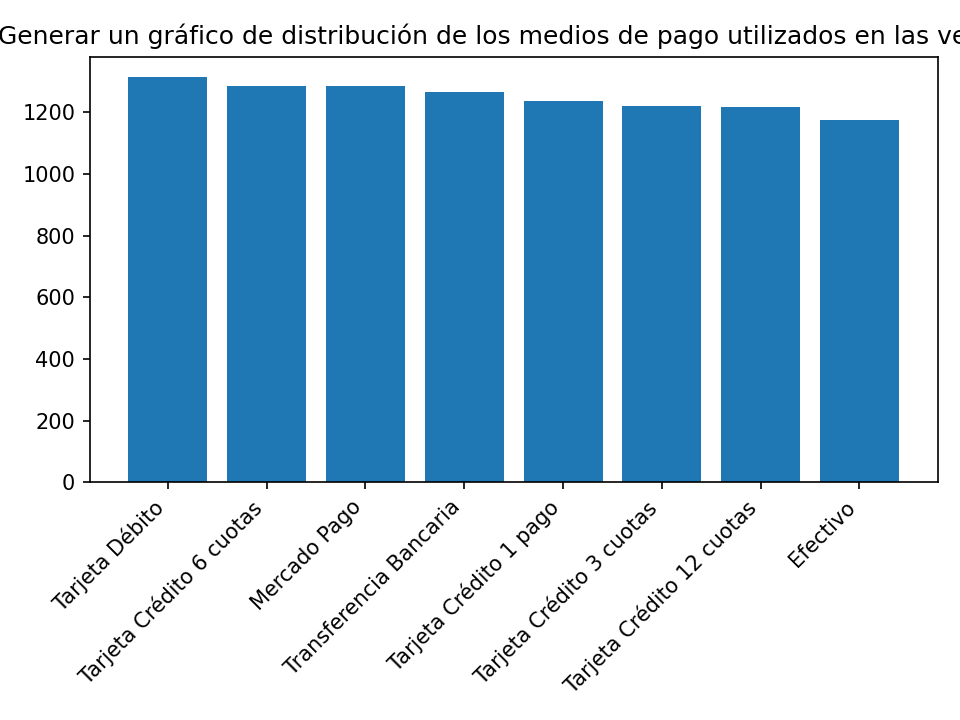


🤖 Asistente: Aquí tienes el gráfico de distribución de los medios de pago utilizados en las ventas. La ruta del gráfico es: /content/plots/plot_analytics.png 

😊 Usuario: ¿Cómo uso mi licuadora para hacer smoothies?

🤖 Asistente: Para preparar un smoothie de frutas en tu licuadora Compacto, te recomiendo seguir estos pasos:

1.  Lavar y cortar las frutas en trozos medianos (2-3 cm).
2.  Colocar los ingredientes líquidos primero (leche, yogurt, jugo).
3.  Agregar las frutas y hielo en la jarra.
4.  Cerrar la tapa asegurándote del cierre hermético.
5.  Comenzar en velocidad baja (nivel 1-2) por 10 segundos.
6.  Aumentar gradualmente a velocidad alta (nivel 4-5).
7.  Procesar durante 45-60 segundos hasta obtener una textura homogénea.
8.  Usar la función PULSE para romper trozos grandes si es necesario.
9.  Verificar la consistencia y procesar 10-15 segundos adicionales si hace falta.
10. Apagar y desconectar antes de retirar la jarra.
11. Servir inmediatamente para un mejor sabor y text

In [125]:
chat_interactivo_agente()